In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan, prepare_frame, filtro_dipolos
)

def intensidad_func(tph, tau, Pc):
    npump = 40000
    return npump*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))


def tau_func(T, e_kb, tau_0):
    return tau_0/(T**2)*np.exp(e_kb/T)


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    # 127: [
    #     "skipper_data/TRAPS/19NOV2023_127K/",
    #     "skipper_data/TRAPS/20NOV2023_127K/",
    # ],
    135: ["skipper_data/TRAPS/27NOV2023_135K/"],
    140: ["skipper_data/TRAPS/23NOV2023_140K/"],
    145: ["skipper_data/TRAPS/25NOV2023_145K/"],
    150: ["skipper_data/TRAPS/22NOV2023_150K/"],
    160: ["skipper_data/TRAPS/12DIC2023_160K/"],
    165: [
        # "skipper_data/TRAPS/06DIC2023_165K/",
        "skipper_data/TRAPS/07DIC2023_165K/",
        "skipper_data/TRAPS/09DIC2023_165K/",
    ],
}
DATA_DIR_COUNT = sum([len(dir_list) for dir_list in CARPETAS_POR_TEMP.values()])
RESULTS_DIR = "skipper_image_analysis/TRAPS_results_normalized"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array([50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200])
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

bounds = np.arange(135-2.5, 170+2.5, 5)
norm = mcolors.BoundaryNorm(bounds, plt.cm.plasma.N, extend="max")
temp_colors = plt.cm.ScalarMappable(
    norm=norm,
    cmap="plasma",
)
dtph_colors = plt.cm.ScalarMappable(
    norm=mcolors.LogNorm(DTPH_VALS[0]/CLOCKS_TO_SEC, DTPH_VALS[-1]/CLOCKS_TO_SEC),
    cmap="viridis"
)
# norm = mcolors.BoundaryNorm(DTPH_BINS/CLOCKS_TO_SEC, plt.cm.viridis.N)
# dtph_colors = plt.cm.ScalarMappable(
#     norm=norm,
#     cmap="viridis"
# )

In [12]:
# Cálculo errores de lectura a NSAMP=20
errores_lectura = []
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        files_in_dir = [file for file in os.listdir(data_dir) if file.endswith(".fits")]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        for file in files_in_dir:
            test_image = fits.open(f'{data_dir}/{file}')
            dtph = int(file.rsplit("_")[5][4:])
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            for frame_idx in [0, 1]:
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                overscan = test_frame[:, -col_overscan_len:]
                errores_lectura.append(overscan.std(ddof=1))
errores_lectura = np.array(errores_lectura)
print(errores_lectura[errores_lectura < 5].mean())
print(errores_lectura[errores_lectura < 5].std(ddof=1))

4.2940726
0.25286162


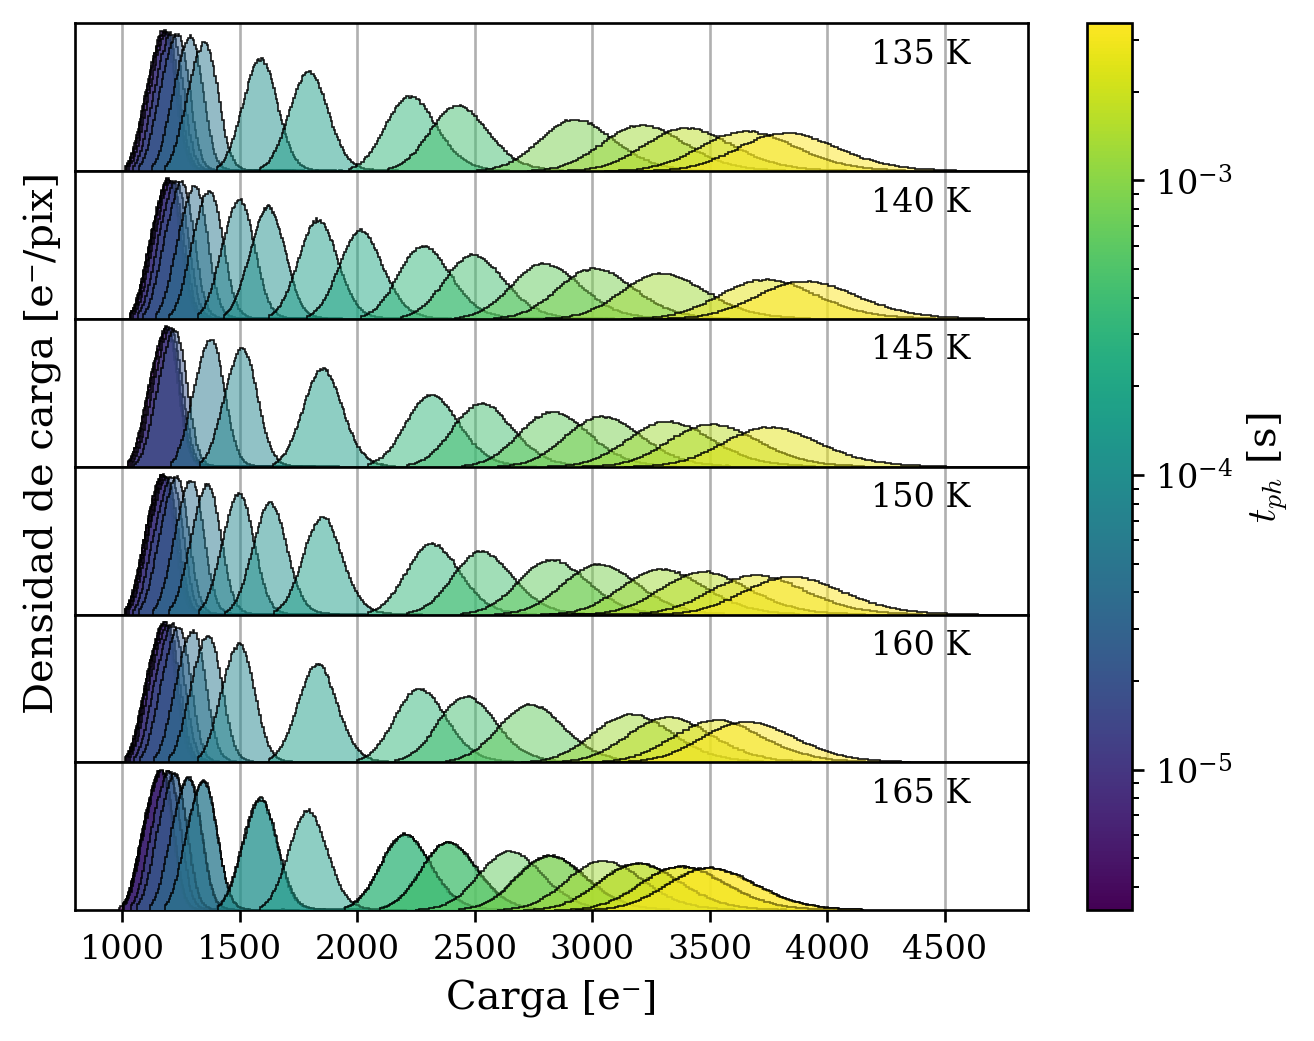

In [4]:
# Graficamos la distribución de carga para cada barrido
plt.close("all")
%matplotlib inline    
dists_por_dir = {}

fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True)
fig.subplots_adjust(hspace=0)
ax_idx = 0
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        files_in_dir = [file for file in os.listdir(data_dir) if file.endswith(".fits")]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        tph_vals = []
        medianas = []
        standard_devs =  []
        ax = axs[ax_idx]
        for file in files_in_dir:
            test_image = fits.open(f'{data_dir}/{file}')
            # print(data_dir, file, sep="")
            dtph = int(file.rsplit("_")[5][4:])
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            carga_area_activa = []
            for frame_idx in [0, 1]:
                # area_activa, _, _ = prepare_frame(test_image, frame_idx)
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame[-row_overscan_len:, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame.copy()
                carga_area_activa.append(area_activa.flatten())
            carga_area_activa = np.concatenate(carga_area_activa)
            medianas.append(np.median(carga_area_activa))
            carga_area_activa = carga_area_activa[
                (carga_area_activa > np.quantile(carga_area_activa, 0.005))
                & (carga_area_activa < np.quantile(carga_area_activa, 0.99))
            ]
            standard_devs.append(
                np.std(
                    carga_area_activa,
                    ddof=1
                )
            )
            tph_vals.append(dtph/CLOCKS_TO_SEC)
            ax.hist(
                carga_area_activa,
                bins=100,
                color=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
                alpha=0.5, density=True, zorder=10
            )
            ax.hist(
                carga_area_activa,
                bins=100,
                color="k", histtype="step", lw=0.5,
                alpha=0.9, density=True, zorder=10
            )
        dists_por_dir[data_dir] = (medianas, standard_devs, tph_vals)
    # ax.set_xticks([])
    # ax.set_xlim(1000, 4500)
    ax.text(0.94, 0.9, f"{temperatura} K",
            # c=temp_colors.to_rgba(temperatura),
            transform=ax.transAxes, ha="right", va="top")
    ax.grid(True)
    ax.set_yticks([])
    # ax.set_ylabel(f"{temperatura} K")
    if ax_idx == 1:
        ax.set_ylabel("Densidad de carga [e⁻/pix]", loc="top")
    ax_idx += 1
# ax.set_xticks(range(1000, 5000, 500))
# ax.set_xlim(1000, 4500)
ax.set_xlabel("Carga [e⁻]")
fig.colorbar(dtph_colors, label="$t_{ph}$ [s]", ax=axs)
plt.show()
        

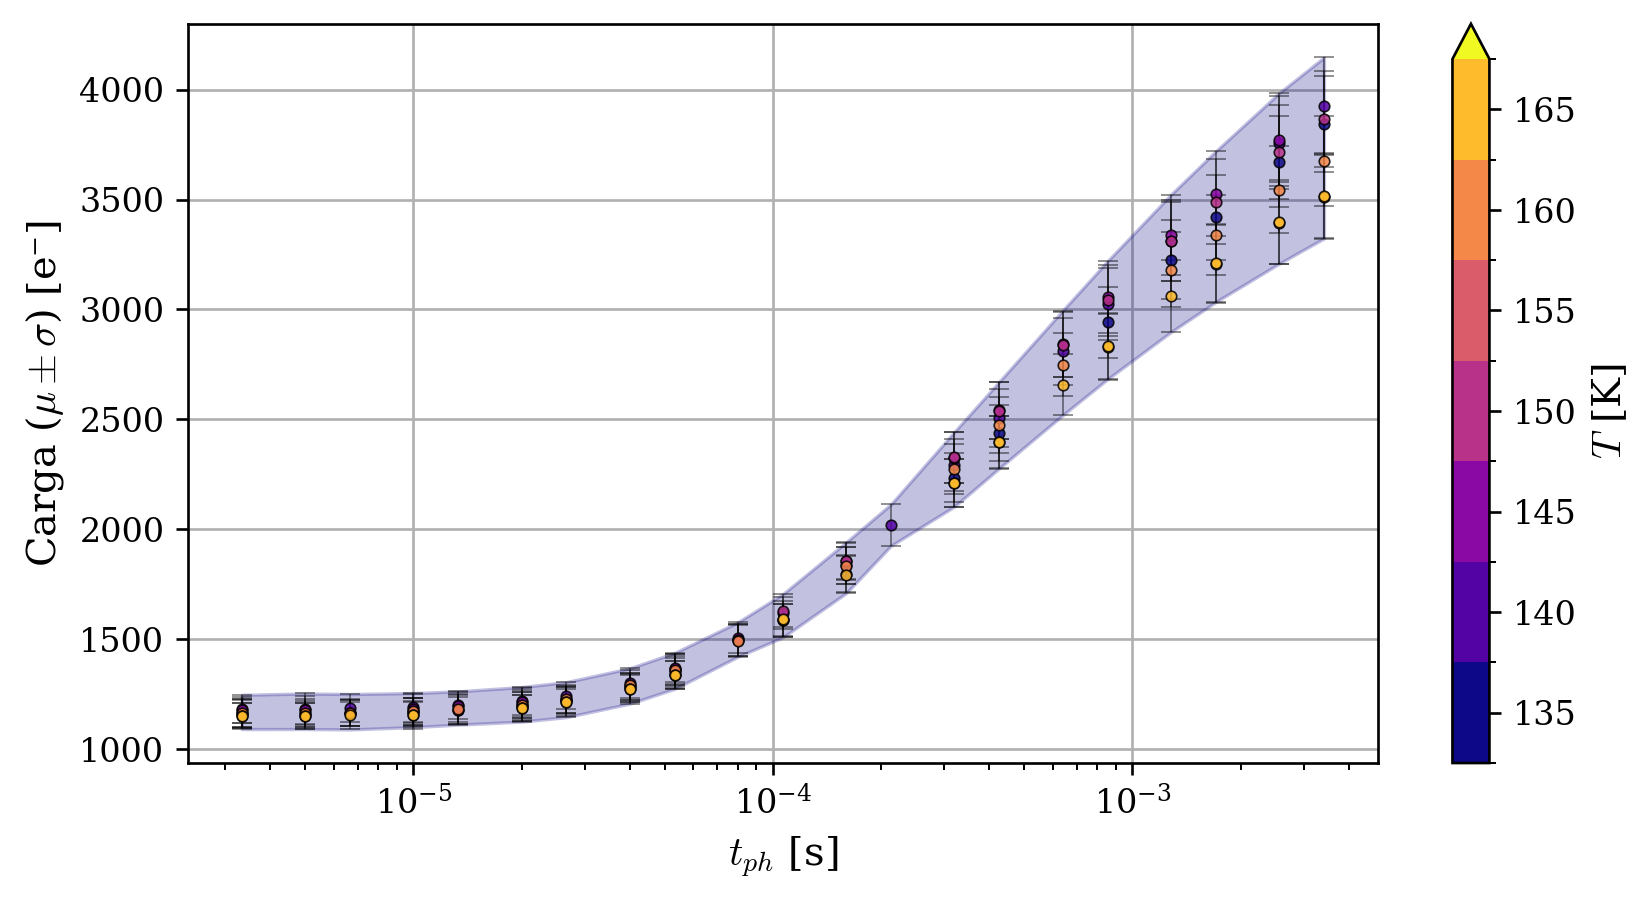

In [5]:
# Graficamos la carga media en función del t_ph
plt.figure(figsize=(8, 4))
median_vals = np.full(
    (DATA_DIR_COUNT, len(DTPH_VALS)), np.nan
)
std_vals = np.full(
    (DATA_DIR_COUNT, len(DTPH_VALS)), np.nan
)
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
        plt.scatter(tph_vals, medianas, color=temp_colors.to_rgba(temperatura), zorder=10,
                    linewidth=0.5, edgecolor="k", alpha=0.85, s=10)
        plt.errorbar(tph_vals, medianas, yerr=standard_devs, ls="none", zorder=5,
                        color="k", mec="k", mew=0.5, lw=0.5, capsize=3, alpha=0.5)
        
        dir_idx = list(CARPETAS_POR_TEMP.keys()).index(temperatura)
        for tph_idx, t_ph in enumerate(DTPH_VALS/CLOCKS_TO_SEC):
            if t_ph in tph_vals:
                tph_data_idx = tph_vals.index(t_ph)
                median_vals[dir_idx, tph_idx] = medianas[tph_data_idx]
                std_vals[dir_idx, tph_idx] = standard_devs[tph_data_idx]
plt.fill_between(
    DTPH_VALS/CLOCKS_TO_SEC,
    np.nanmin(median_vals - std_vals, axis=0),
    np.nanmax(median_vals + std_vals, axis=0),
    color=temp_colors.to_rgba(0), alpha=0.25, zorder=4
)
plt.grid()
plt.xscale("log")
plt.xlabel("$t_{ph}$ [s]")
plt.ylabel("Carga ($\mu \pm \sigma$) [e⁻]")
plt.colorbar(temp_colors, label="$T$ [K]", ax=plt.gca(), ticks=temp_colors.norm.boundaries+2.5)
plt.show()

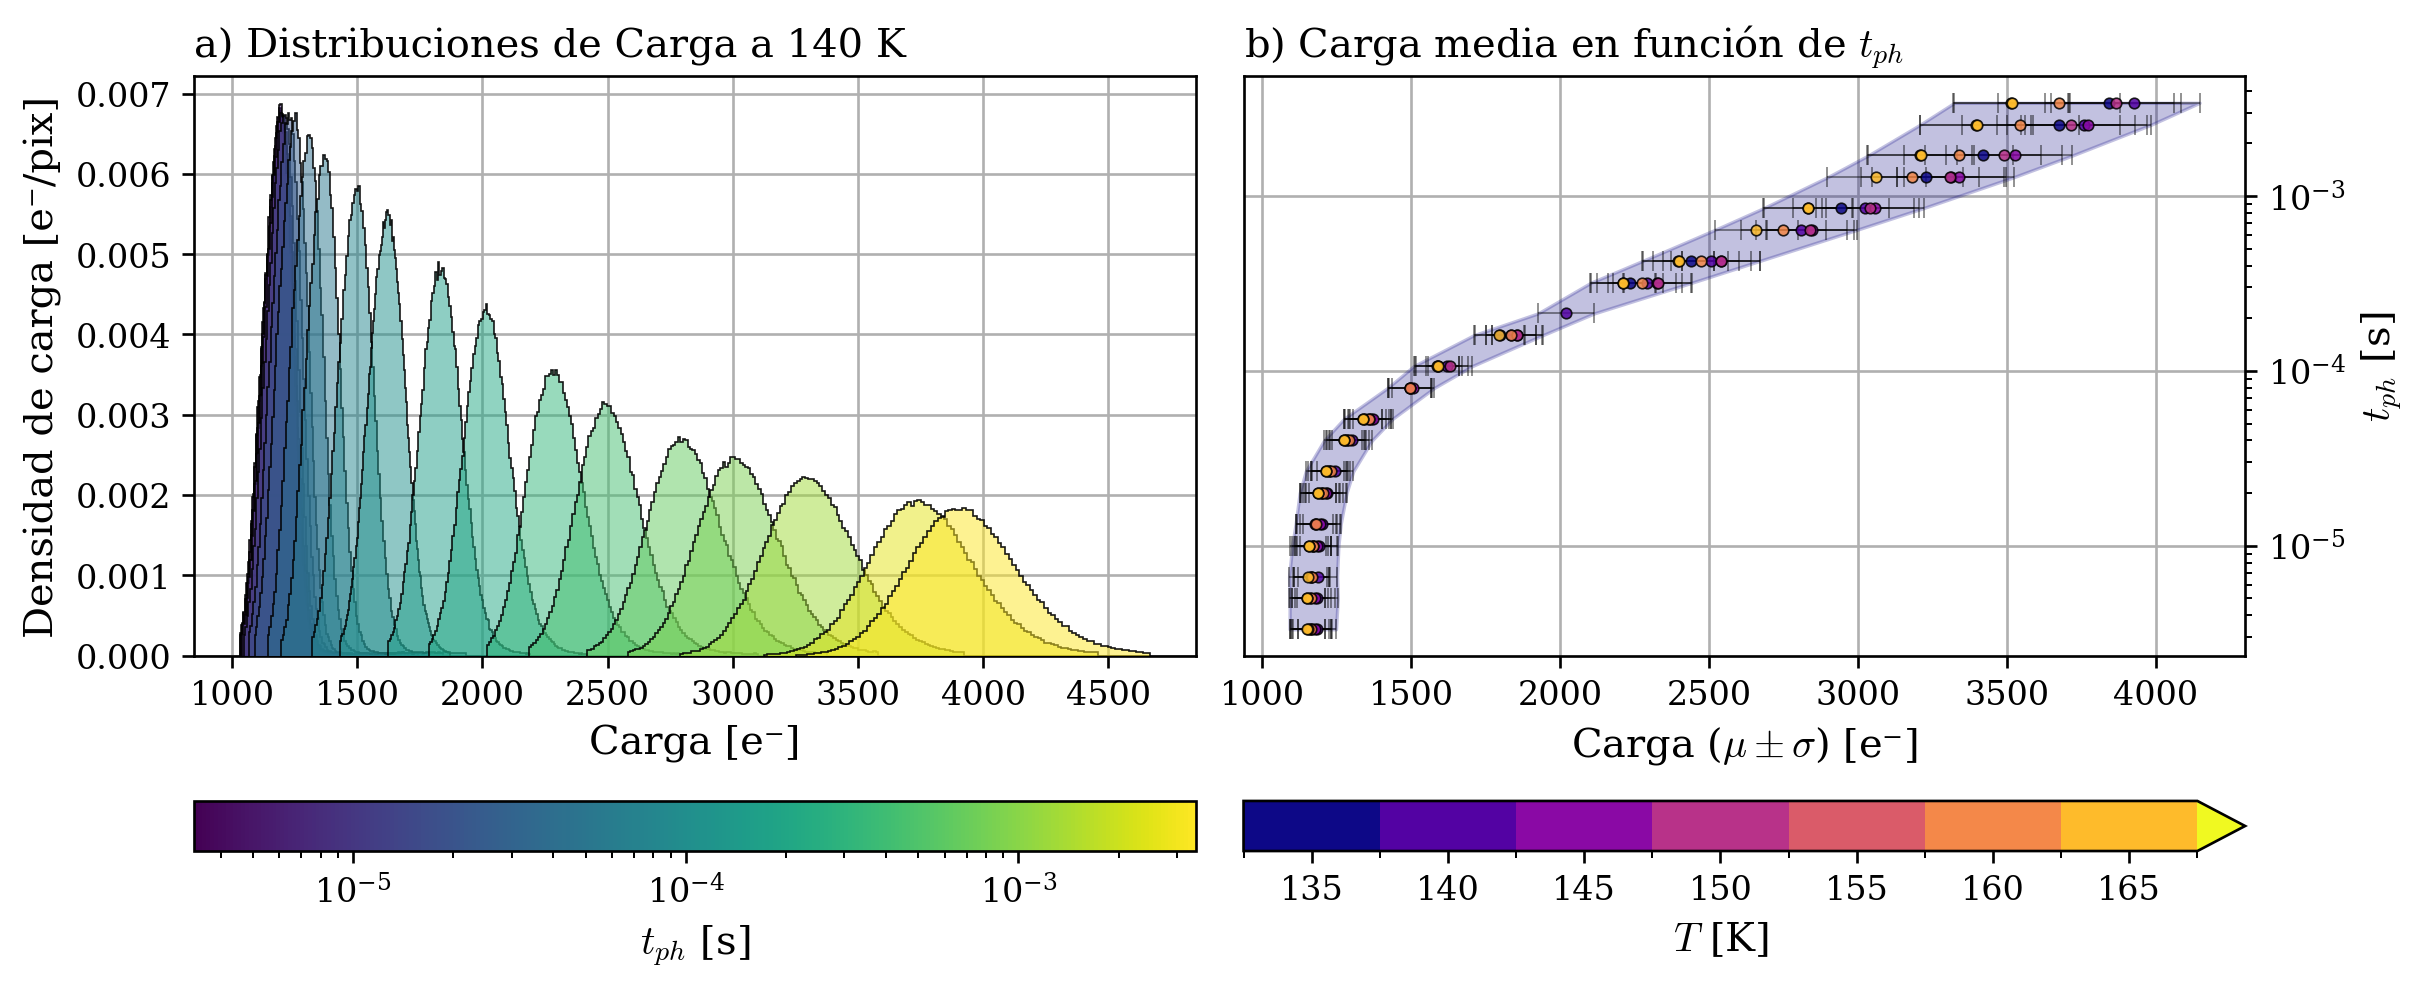

In [6]:
# Grafico conjunto para el informe
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
axs[0].set_title("a) Distribuciones de Carga a 140 K", loc="left")
axs[1].set_title("b) Carga media en función de $t_{ph}$", loc="left")
temperatura = 140
data_dir = CARPETAS_POR_TEMP[temperatura][0]
files_in_dir = [file for file in os.listdir(data_dir) if file.endswith(".fits")]
files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))

for file in files_in_dir:
    test_image = fits.open(f'{data_dir}/{file}')
    # print(data_dir, file, sep="")
    dtph = int(file.rsplit("_")[5][4:])
    row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
    test_image = correct_overscan(test_image)
    carga_area_activa = []
    for frame_idx in [0, 1]:
        # area_activa, _, _ = prepare_frame(test_image, frame_idx)
        test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
        area_activa = test_frame[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]
        # area_activa = test_frame.copy()
        carga_area_activa.append(area_activa.flatten())
    carga_area_activa = np.concatenate(carga_area_activa)
    carga_area_activa = carga_area_activa[
        (carga_area_activa > np.quantile(carga_area_activa, 0.005))
        & (carga_area_activa < np.quantile(carga_area_activa, 0.99))
    ]
    axs[0].hist(
        carga_area_activa,
        bins=100,
        color=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
        alpha=0.5, density=True, zorder=10,
        # orientation="horizontal",
    )
    axs[0].hist(
        carga_area_activa,
        bins=100,
        color="k", histtype="step", lw=0.5,
        alpha=0.9, density=True, zorder=10,
        # orientation="horizontal",
    )
axs[0].grid()
plt.colorbar(dtph_colors, label="$t_{ph}$ [s]", ax=axs[0], location="bottom")
axs[0].set_ylabel("Densidad de carga [e⁻/pix]")
axs[0].set_xlabel("Carga [e⁻]")

for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
        axs[1].scatter(
            # tph_vals, medianas,
            medianas, tph_vals,
            color=temp_colors.to_rgba(temperatura), zorder=10,
            linewidth=0.5, edgecolor="k", alpha=0.85, s=10,
        )
        axs[1].errorbar(
            # tph_vals, medianas, yerr=standard_devs,
            medianas, tph_vals, xerr=standard_devs,
            ls="none", zorder=5,
            color="k", mec="k", mew=0.5, lw=0.5, capsize=3, alpha=0.5,
        )
        
        dir_idx = list(CARPETAS_POR_TEMP.keys()).index(temperatura)
        for tph_idx, t_ph in enumerate(DTPH_VALS/CLOCKS_TO_SEC):
            if t_ph in tph_vals:
                tph_data_idx = tph_vals.index(t_ph)
                median_vals[dir_idx, tph_idx] = medianas[tph_data_idx]
                std_vals[dir_idx, tph_idx] = standard_devs[tph_data_idx]
axs[1].fill_betweenx(
    DTPH_VALS/CLOCKS_TO_SEC,
    np.nanmin(median_vals - std_vals, axis=0),
    np.nanmax(median_vals + std_vals, axis=0),
    color=temp_colors.to_rgba(0), alpha=0.25, zorder=4
)
axs[1].grid()
axs[1].set_yscale("log")
axs[1].set_ylabel("$t_{ph}$ [s]")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xlabel("Carga ($\mu \pm \sigma$) [e⁻]")
plt.colorbar(temp_colors, label="$T$ [K]", ax=axs[1], ticks=temp_colors.norm.boundaries+2.5, location="bottom")
plt.show()

In [7]:
def plot_region_con_margenes(
    main_ax_data: ArrayLike,
    x_margin_data: ArrayLike,
    y_margin_data: ArrayLike,
    main_ax_aspect=1,
) -> tuple[plt.Figure, plt.Axes, plt.Axes, plt.Axes]:
    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    main_ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    x_ax = main_ax.inset_axes([0, 1.0, 1, 0.25])
    x_ax.tick_params(axis='x', labelbottom=False, bottom=False)
    y_ax = main_ax.inset_axes([1.0, 0, 0.25, 1])
    y_ax.tick_params(axis='y', labelleft=False, left=False)
    # Draw the scatter plot and marginals.
    main_ax.imshow(
        main_ax_data,
        aspect=main_ax_aspect,
        origin='lower',
    )
    if x_margin_data.size == main_ax_data.shape[1]:
        x_ax.plot(np.arange(main_ax_data.shape[1]), x_margin_data)
        x_ax.sharex(main_ax)
    else:
        x_ax.plot(x_margin_data)
    if y_margin_data.size == main_ax_data.shape[0]:
        y_ax.plot(y_margin_data, np.arange(main_ax_data.shape[0]))
        y_ax.sharey(main_ax)
    else:
        y_ax.plot(y_margin_data, range(len(y_margin_data)))
    return fig, main_ax, x_ax, y_ax

skipper_data/TRAPS/23NOV2023_140K/proc_skp_pocket_oled1row_2film_dTph75_NPUPMPS40000_NSAMP20_NROW879_NCOL336_EXPOSURE8.0_img89.fits


/tmp/ipykernel_3632/3380549216.py:26: RuntimeWarning: Mean of empty slice
  y_margin_data=np.nanmean(area_activa_filtrada, axis=1),
/tmp/ipykernel_3632/3380549216.py:37: RuntimeWarning: Mean of empty slice
  np.nanmean(area_activa_filtrada, axis=1),
/home/agustin/Documents/FCEN/2023_1er_Cuatrimestre/Laboratorio_6&7/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


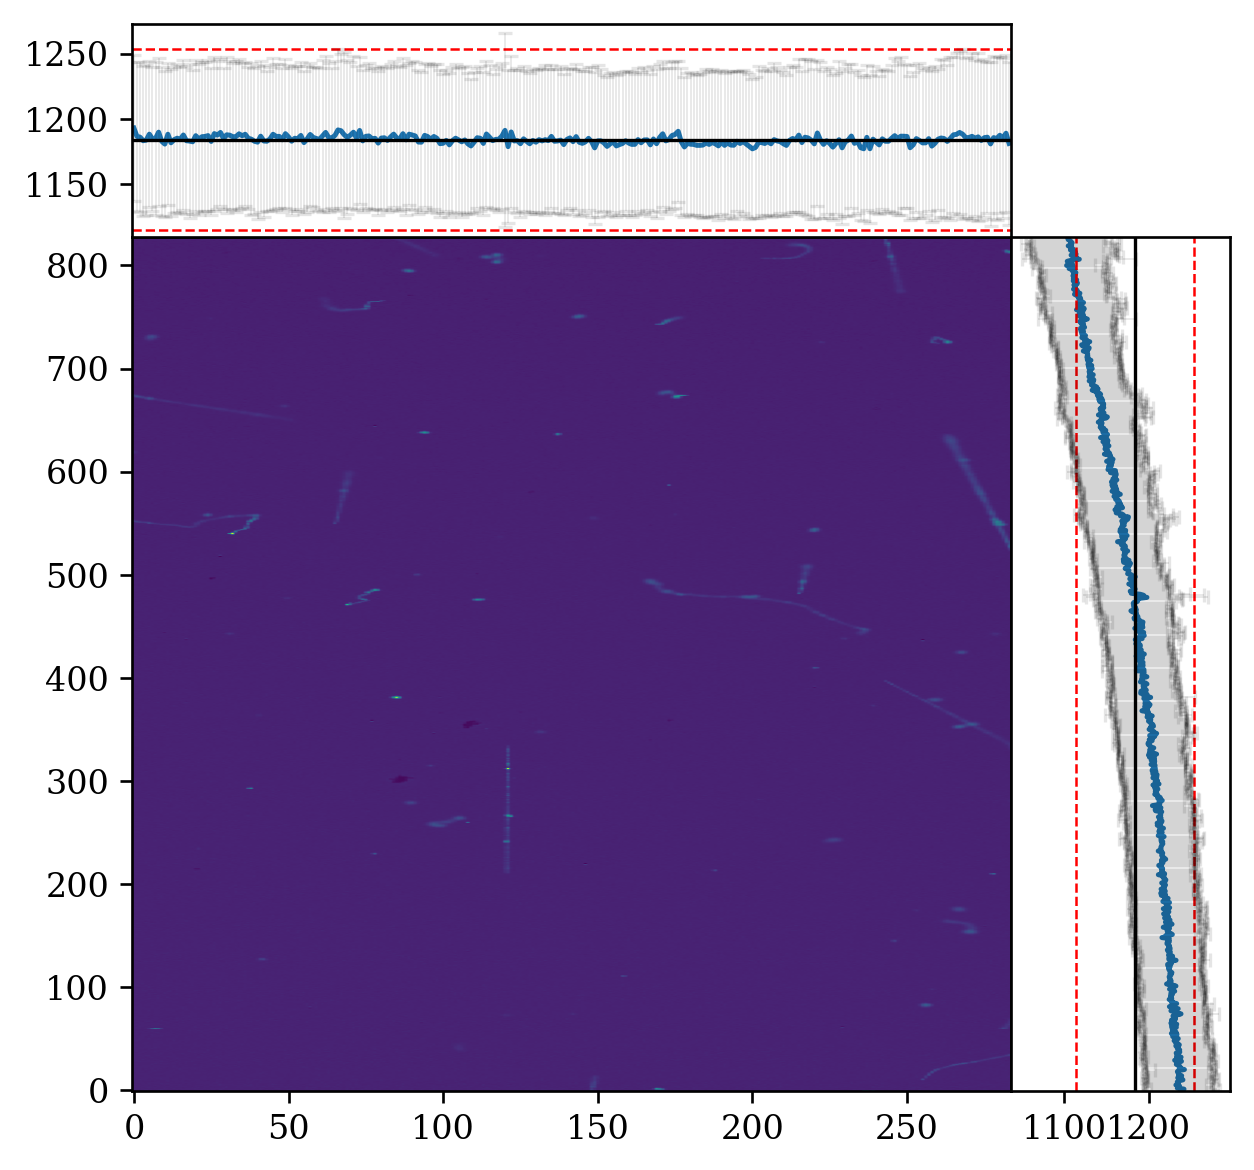

In [8]:
# Graficamos valores centrales en filas y columnas
data_dir = CARPETAS_POR_TEMP[140][0]
files_in_dir = [file for file in os.listdir(data_dir) if file.endswith(".fits")]
files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
file_idx = 1
test_image = fits.open(f'{data_dir}/{files_in_dir[file_idx]}')
row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
test_image = correct_overscan(test_image)
print(data_dir, files_in_dir[file_idx], sep="")
frame_idx = 0
test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
area_activa = test_frame[1:-row_overscan_len, PRESCAN_PIX+2:-col_overscan_len]
filtro_inf = area_activa > np.quantile(area_activa, 0.005)
filtro_sup = area_activa < np.quantile(area_activa, 0.99)
area_activa_filtrada = np.where(filtro_inf & filtro_sup, area_activa, np.nan)

# # Convert the filtered array to a 2D array
# area_activa_filtrada_2d = np.reshape(area_activa_filtrada, area_activa.shape)


fig, main_ax, x_ax, y_ax = plot_region_con_margenes(
    area_activa,
    # x_margin_data=np.nanstd(area_activa_filtrada, axis=0),
    # y_margin_data=np.nanstd(area_activa_filtrada, axis=1),
    x_margin_data=np.nanmean(area_activa_filtrada, axis=0),
    y_margin_data=np.nanmean(area_activa_filtrada, axis=1),
    main_ax_aspect=1/3,
)
x_ax.errorbar(
    np.arange(area_activa.shape[1]),
    np.nanmean(area_activa_filtrada, axis=0),
    yerr=np.nanstd(area_activa_filtrada, axis=0, ddof=1),
    fmt="", ls="", ecolor="k", capsize=2, elinewidth=0.5,
    zorder=50, alpha=0.1,
)
y_ax.errorbar(
    np.nanmean(area_activa_filtrada, axis=1),
    np.arange(area_activa.shape[0]),
    xerr=np.nanstd(area_activa_filtrada, axis=1, ddof=1),
    fmt="", ls="", ecolor="k", capsize=2, elinewidth=0.5,
    zorder=50, alpha=0.1,
)

medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
for ax_plot_line in [x_ax.axhline, y_ax.axvline]:
    # ax_plot_line(standard_devs[file_idx], c="k", ls="-", lw=1)
    ax_plot_line(medianas[file_idx], c="k", ls="-", lw=1)
    ax_plot_line(medianas[file_idx] - standard_devs[file_idx], c="r", ls="--", lw=0.75)
    ax_plot_line(medianas[file_idx] + standard_devs[file_idx], c="r", ls="--", lw=0.75)
plt.show()

In [9]:
def frame_coords_to_ccd_coords(
    coord: tuple[int, int], frame_idx: int, CCDNROWS: int, CCDNCOLS: int
) -> tuple[int, int]:
    """Transforma las coordenadas relativas a un frame a las coordenadas de la \
CCD considerando el frame y el overscan.
    """
    x, y = coord
    row = x
    col = y
    if frame_idx in [1, 3]:
        col = CCDNCOLS - y - 1
    if frame_idx in [2, 3]:
        row = CCDNROWS - x - 1
    return row, col


def ccd_coords_to_frame_coords(
    coord: tuple[int, int], frame_idx: int, CCDNROWS: int, CCDNCOLS: int
) -> tuple[int, int]:
    """Transforma las coordenadas relativas a la CCD a las coordenadas de un \
frame considerando el frame y el overscan.
    """
    row, col = coord
    y = col
    x = row
    if frame_idx in [1, 3]:
        y = CCDNCOLS - col - 1
    if frame_idx in [2, 3]:
        x = CCDNROWS - row - 1
    return x, y

# CCDNROW = 24
# CCDNCOL = 18
# test_coords = [
#     (0, y) for y in range(CCDNCOL//2 - 1)
# ] + [
#     (x, CCDNCOL//2 - 1) for x in range(CCDNROW//2)
# ] + [
#     (CCDNROW//2 - 1, y) for y in range(CCDNCOL//2 - 1)
# ][::-1] + [
#     (x, 0) for x in range(1, CCDNROW//2 - 1)
# ][::-1]
# x_vals = []
# y_vals = []
# i_vals = []
# j_vals = []
# for frame_idx in range(4):
#     for x, y in test_coords:
#         i, j = frame_coords_to_ccd_coords((x, y), frame_idx, CCDNROW, CCDNCOL)
#         i_vals.append(i)
#         j_vals.append(j)
#         x, y = ccd_coords_to_frame_coords((i, j), frame_idx, CCDNROW, CCDNCOL)
#         x_vals.append(x)
#         y_vals.append(y)


# fig, axs = plt.subplots(1, 2, layout="constrained")
# colors_index = np.linspace(0, 1, len(x_vals)//4)
# sizes_index = np.linspace(60, 20, len(x_vals))
# markers = ["o", "h", "s", "D"]
# axs[0].set_title("Coordenadas Relativas a un Frame\n(Área Activa)")

# for frame_idx, x_batch, y_batch, markerstyle, sizes in zip(
#     range(4), np.array_split(x_vals, 4), np.array_split(y_vals, 4), markers, np.array_split(sizes_index, 4)
# ):
#     axs[0].scatter(
#         y_batch, x_batch, c=colors_index, s=sizes, marker=markerstyle,
#         alpha=1, edgecolors="k", linewidths=0.25, zorder=25,
#         label=f"Frame {frame_idx}"
#     )
# axs[0].grid()
# axs[0].set_yticks([CCDNROW//2 - 1, 0])
# axs[0].set_ylim(CCDNROW//2, -1)
# axs[0].set_ylabel("$x$ [filas]")
# axs[0].set_xticks([0, CCDNCOL//2 - 1])
# axs[0].set_xlim(-1, CCDNCOL//2)
# axs[0].set_xlabel("$y$ [columnas]")

# axs[1].set_title("Coordenadas de la CCD\n(Área Activa)")
# for frame_idx, i_batch, j_batch, markerstyle, sizes in zip(
#     range(4), np.array_split(i_vals, 4), np.array_split(j_vals, 4), markers, np.array_split(sizes_index, 4)
# ):
#     axs[1].scatter(
#         j_batch, i_batch, c=colors_index, s=sizes, marker=markerstyle,
#         alpha=1, edgecolors="k", linewidths=0.25, zorder=25,
#         label=f"Frame {frame_idx}"
#     )
# axs[1].grid()
# axs[1].set_yticks([0, CCDNROW//2 - 1, CCDNROW//2, CCDNROW - 1])
# axs[1].set_ylim(CCDNROW, -1)
# axs[1].set_ylabel("$i$ [filas CCD]")
# axs[1].set_xticks([0, CCDNCOL//2 - 1, CCDNCOL//2, CCDNCOL - 1])
# axs[1].set_xlim(-1, CCDNCOL)
# axs[1].set_xlabel("$j$ [columnas CCD]")
# # axs[1].xaxis.set_label_position("top")
# # axs[1].xaxis.tick_top()
# plt.show()

In [10]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold_factor: float = 4, corte_simetria: float = 30
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold_factor {float, optional}`: Factor por el que se multiplica al \
ancho de la distribución de carga en la CCD para calcular el umbral de selección. Es \
decir, un dipolo se considera válido si su autocorrelación es menor que \
`-(threshold_factor * ancho_dist)**2`, donde `ancho_dist` es el ancho de la distribución \
de carga en la CCD. Valor por defecto = 3.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
    files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
    frames_dict = dict()
    mediana_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos", leave=True):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], mediana_dict[dtph], error_dict[dtph] = prepare_frame(
            test_image, frame_idx, remove_row_median=True,
        )  # e⁻
        # if error_dict[dtph] > 1e3:  # Si el error es muy grande, descartar el frame
        #     # Por el NSAMP=20 sabemos que el error de lectura es del orden de 10 e⁻
        #     del frames_dict[dtph], error_dict[dtph]
        #     continue
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold_factor, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, mediana_dict, error_dict, mascara_dipolos

In [11]:
def identificacion_e_intensidad(
    coords_dict: dict,
    frames_dict: dict,
    vals_dict: dict,
    mediana_dict: dict,
    errors_dict: dict,
) -> tuple[list, list, list, list]:
    """Identifica trampas en todos los dtph y busca la intensidad de cada trampa en \
todos los dtph.
    """
    trampas_halladas = []
    intensidad_por_trampa = []
    error_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    error_vals = [  # e⁻
        errors_dict[dtph]/np.sqrt(2) for dtph in dtph_vals
    ]  # Error propagado al calcular la intensidad como la mitad de la diferencia
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
        leave=False,
    ):
        coordenadas_trampas = coords_dict[dtph]
        valores_trampas = vals_dict[dtph]
        mediana_trampas = mediana_dict[dtph]
        for coords, valor in zip(
            coordenadas_trampas, valores_trampas
        ):
            if coords in trampas_halladas:
                # Si ya se encontró la trampa, no hace falta volver a propagar.
                propagar_a_todos = False
            elif valor > (mediana_trampas / 3):
                # Si la intensidad del dipolo es mayor a la mitad de la carga media
                # de la CCD, entonces seguro es una trampa y hay que propagarla.
                propagar_a_todos = True
            elif sum([coords in coords_dict[t_ph] for t_ph in dtph_vals]) >= 2:
                # Si la trampa está en más de dos dtph, entonces seguro es una trampa
                # y hay que propagarla.
                propagar_a_todos = True
            else:
                # Si no se cumple ninguna de las condiciones anteriores, no se
                # propaga la trampa.
                propagar_a_todos = False
            if propagar_a_todos:
                # Propagar la trampa a todos los dtph y guardamos las curvas de I(t_ph).
                intensidades_trampa = []
                for dtph_frames in dtph_vals:
                    frame = frames_dict[dtph_frames]
                    intensidad_trampa = np.abs(  # e⁻
                        frame[coords[0]] - frame[coords[1]]
                    ) / 2
                    intensidades_trampa.append(intensidad_trampa)
                error_por_trampa.append(error_vals)
                intensidad_por_trampa.append(intensidades_trampa)
                trampas_halladas.append(coords)
    return trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals

## Análisis de la Intensidad de las Trampas

In [13]:
def process_temperature(temperatura, carpetas):
    trampas = []  # trampas[dir_idx][coord_idx]
    intensidad = []  # intensidad[dir_idx][coord_idx][dtph_idx]
    dtph = []  # dtph[dir_idx][dtph_idx]
    error = []  # error[dir_idx][coord_idx][dtph_idx]
    for dir_idx in range(len(carpetas)):
        print(f"Procesando Carpeta {carpetas[dir_idx]}...")
        for frame_idx in [0, 1]:
            print(f"Recorriendo Frame {frame_idx}...")
            coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict, _ = carga_archivos(
                temperatura, dir_idx, frame_idx, threshold_factor=3, corte_simetria=30,
            )
            trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals = identificacion_e_intensidad(
                coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict
            )
            # Transformamos las coordenadas de los dipolos al sistema de coords de la CCD
            CCDNROW = int(test_image[frame_idx].header["CCDNROW"])
            CCDNCOL = int(test_image[frame_idx].header["CCDNCOL"])
            trampas_halladas = [
                (
                    frame_coords_to_ccd_coords(coords[0], frame_idx, CCDNROW, CCDNCOL),
                    frame_coords_to_ccd_coords(coords[1], frame_idx, CCDNROW, CCDNCOL),
                ) for coords in trampas_halladas
            ]
            trampas.append(trampas_halladas)
            intensidad.append(intensidad_por_trampa)
            error.append(error_por_trampa)
            dtph.append(dtph_vals)
    return trampas, intensidad, error, dtph, temperatura

try:
    trampas_temp = pickle.load(open(f"{RESULTS_DIR}/trampas.pkl", "rb"))
    intensidades_temp = pickle.load(open(f"{RESULTS_DIR}/intensidades.pkl", "rb"))
    errores_temp = pickle.load(open(f"{RESULTS_DIR}/errores.pkl", "rb"))
    dtph_temp = pickle.load(open(f"{RESULTS_DIR}/dtph.pkl", "rb"))
    print(f"Resultados intermedios cargados desde Pickles en {RESULTS_DIR}")
except FileNotFoundError:
    trampas_temp: dict[int, list[list[tuple[tuple[int]]]]] = dict()
    intensidades_temp: dict[int, list[list[list[float]]]] = dict()
    errores_temp: dict[int, list[list[list[float]]]] = dict()
    dtph_temp: dict[int, list[list[int]]] = dict()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for temperatura, carpetas in CARPETAS_POR_TEMP.items():
            futures.append(executor.submit(process_temperature, temperatura, carpetas))
        
        for future in concurrent.futures.as_completed(futures):
            trampas, intensidad, error, dtph, temperatura = future.result()
            trampas_temp[temperatura] = trampas
            intensidades_temp[temperatura] = intensidad
            errores_temp[temperatura] = error
            dtph_temp[temperatura] = dtph
    # Save to Pickle
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    with open(f"{RESULTS_DIR}/trampas.pkl", "wb") as file:
        pickle.dump(trampas_temp, file)
    with open(f"{RESULTS_DIR}/intensidades.pkl", "wb") as file:
        pickle.dump(intensidades_temp, file)
    with open(f"{RESULTS_DIR}/errores.pkl", "wb") as file:
        pickle.dump(errores_temp, file)
    with open(f"{RESULTS_DIR}/dtph.pkl", "wb") as file:
        pickle.dump(dtph_temp, file)

Resultados intermedios cargados desde Pickles en skipper_image_analysis/TRAPS_results_normalized


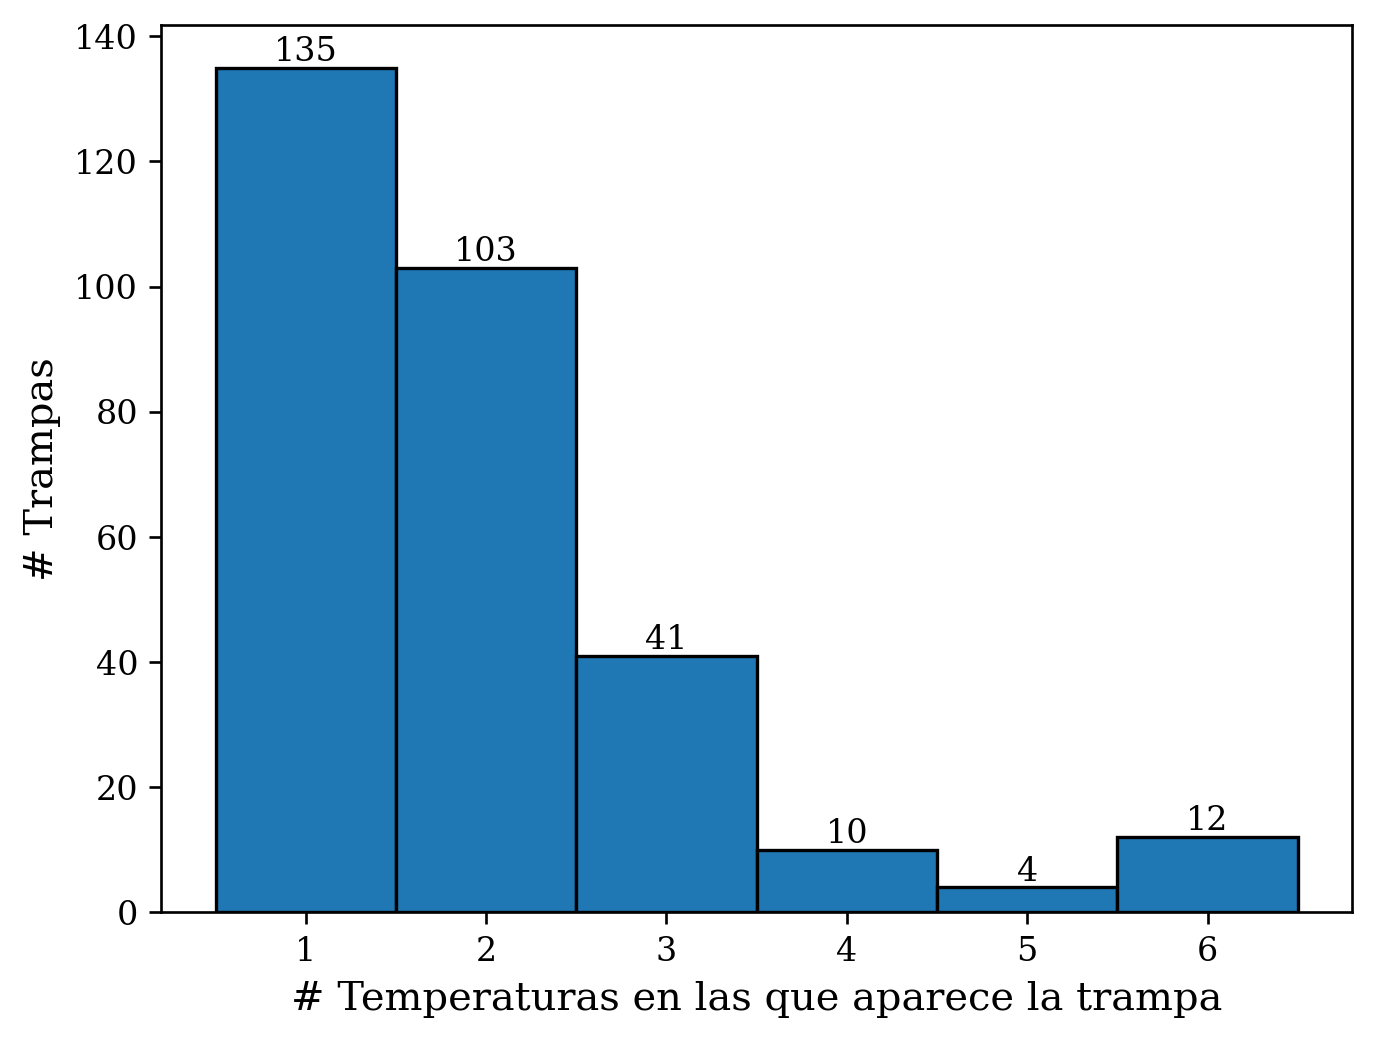

In [14]:
trampas_unicas_por_temp = dict()
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    trampas_unicas = []
    for dir_idx, _ in enumerate(carpetas):
        for frame_idx in [0, 1]:
            trampas_unicas.extend(trampas_temp[temperatura][2*dir_idx + frame_idx])
    trampas_unicas = set(trampas_unicas)
    trampas_unicas_por_temp[temperatura] = trampas_unicas

lista_todas_trampas = [list(trampas_temp) for trampas_temp in trampas_unicas_por_temp.values()]
lista_todas_trampas = sum(lista_todas_trampas, [])
cuentas = pd.value_counts(lista_todas_trampas).values
counts, bins = np.histogram(cuentas, bins=np.arange(0.5, cuentas.max() + 1.5, 1))
plt.bar(bins[:-1], counts, width=1, align="edge", ec="k")
for count, bin in zip(counts, bins[:-1]):
    plt.text(
        bin + 0.5,
        count,
        f"{count}",
        ha="center", va="bottom",
    )
plt.xlabel("# Temperaturas en las que aparece la trampa")
plt.ylabel("# Trampas")
plt.show()

In [16]:
# Calculo Máscaras por Saturación
mascara_saturacion_temp: dict[int, list[list[list[bool]]]] = dict()
# [temperaturaa][dir_idx][coord_idx][dtph_idx]
for temperatura, carpetas in tqdm(CARPETAS_POR_TEMP.items(), desc="Temperaturas"):
    mascaras_temperatura = []
    for dir_idx, data_dir in enumerate(carpetas):
        
        files_in_dir = [file for file in os.listdir(data_dir) if file.endswith(".fits")]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx])
        umbrales_dtph: dict[int, list[ArrayLike]] = dict()  # [dtph][frame_idx][row_idx]
        for dtph, file in zip(dtph_vals, files_in_dir):
            test_image = fits.open(f'{data_dir}/{file}')
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            umbrales_dtph[dtph] = []  # para guardar los valores umbrales por fila por dtph
            for frame_idx in [0, 1]:
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[
                    1:-row_overscan_len, PRESCAN_PIX+2:-col_overscan_len
                ]
                filtro_inf = area_activa > np.quantile(area_activa, 0.005)
                filtro_sup = area_activa < np.quantile(area_activa, 0.99)
                area_activa_filtrada = np.where(
                    filtro_inf & filtro_sup,
                    area_activa,
                    np.nan
                )
                umbrales_dtph[dtph].append(
                    np.nanmean(area_activa_filtrada, axis=1)
                    - 3*np.nanstd(area_activa_filtrada, axis=1, ddof=1)
                )
        #         plt.plot(
        #             umbrales_dtph[dtph][frame_idx],
        #             np.arange(area_activa_filtrada.shape[0]),
        #             label=f"Frame {frame_idx}",
        #             c=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
        #         )
        # plt.title(f"Umbral de Saturación para {temperatura} K")
        # plt.xlabel("Umbral [e⁻]")
        # plt.ylabel("Fila")
        # plt.show()
        for frame_idx in [0, 1]:
            mascaras_dir = []
            for coord_idx, (coords, intensidades_mask, errores_mask) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                intensidades_mask = np.array(intensidades_mask)
                errores_mask = np.array(errores_mask)
                mascara_trampa = np.zeros_like(intensidades_mask, dtype=bool)
                fila_trampa = coords[1][0]
                for idx, (dtph, intensidad, error) in enumerate(
                    zip(dtph_vals, intensidades_mask, errores_mask)
                ):
                    umbral = umbrales_dtph[dtph][frame_idx][fila_trampa]
                    mascara_trampa[idx] = (intensidad + error) >= umbral
                    # Si la intensidad + error es mayor al umbral, entonces la trampa
                mascaras_dir.append(mascara_trampa)
            mascaras_temperatura.append(mascaras_dir)
    mascara_saturacion_temp[temperatura] = mascaras_temperatura

Temperaturas:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_3632/2393160618.py:30: RuntimeWarning: Mean of empty slice
  np.nanmean(area_activa_filtrada, axis=1)
/home/agustin/Documents/FCEN/2023_1er_Cuatrimestre/Laboratorio_6&7/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [17]:
total_puntos = 0
puntos_saturan = 0
curvas_saturan = 0
for temp, mascaras in mascara_saturacion_temp.items():
    for dir_idx, mascara_dir in enumerate(mascaras):
        for mascara_coord in mascara_dir:
            # print(mascara_coord)
            total_puntos += mascara_coord.size
            puntos_saturan += np.sum(mascara_coord)
            curvas_saturan += (np.sum(~mascara_coord) < 6)
print(f"Se saturan {puntos_saturan} dipolos de {total_puntos} identificados ({puntos_saturan/total_puntos*100:.2f}%)")
print(f"Se saturan {curvas_saturan} curvas de {len(lista_todas_trampas)} identificadas ({curvas_saturan/len(lista_todas_trampas)*100:.2f}%)")

Se saturan 956 dipolos de 12351 identificados (7.74%)
Se saturan 4 curvas de 713 identificadas (0.56%)


In [ ]:
# Graficamos todas las curvas de intensidad junto a la curva de carga mediana
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for dir_idx, data_dir in enumerate(carpetas):
        medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
        medianas = np.array(medianas)
        standard_devs = np.array(standard_devs)
        plt.fill_between(
            tph_vals,
            medianas + standard_devs,
            medianas - standard_devs,
            color=temp_colors.to_rgba(temperatura), alpha=0.5, zorder=0
        )
        for frame_idx in [0, 1]:
            dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
            for coord_idx, (coords, intensidades_mask, errores_mask, mascara_saturacion) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                    mascara_saturacion_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                intensidades_mask = np.array(intensidades_mask)
                errores_mask = np.array(errores_mask)
                mascara_saturacion = np.array(mascara_saturacion)
                # medianas_filtradas = medianas[mascara_saturacion]
                # correlacion = np.dot(
                #     intensidades - np.mean(intensidades),
                #     medianas_filtradas - np.mean(medianas_filtradas),
                # )
                # if correlacion > (
                #     0.5 * np.linalg.norm(
                #         medianas_filtradas - np.mean(medianas_filtradas)
                #     )**2
                # ):
                #     continue
                plt.errorbar(
                    dtph_vals[~mascara_saturacion]/CLOCKS_TO_SEC,
                    intensidades_mask[~mascara_saturacion],
                    yerr=errores_mask[~mascara_saturacion],
                    fmt=".--",
                    mec="k", mew=0.5, ms=3, capsize=3, elinewidth=0.5,
                    linewidth=0.5,
                )
        plt.title(f"Temperatura = {temperatura} K")
        plt.xscale("log")
        # plt.ylim(0, 2)
        plt.show()

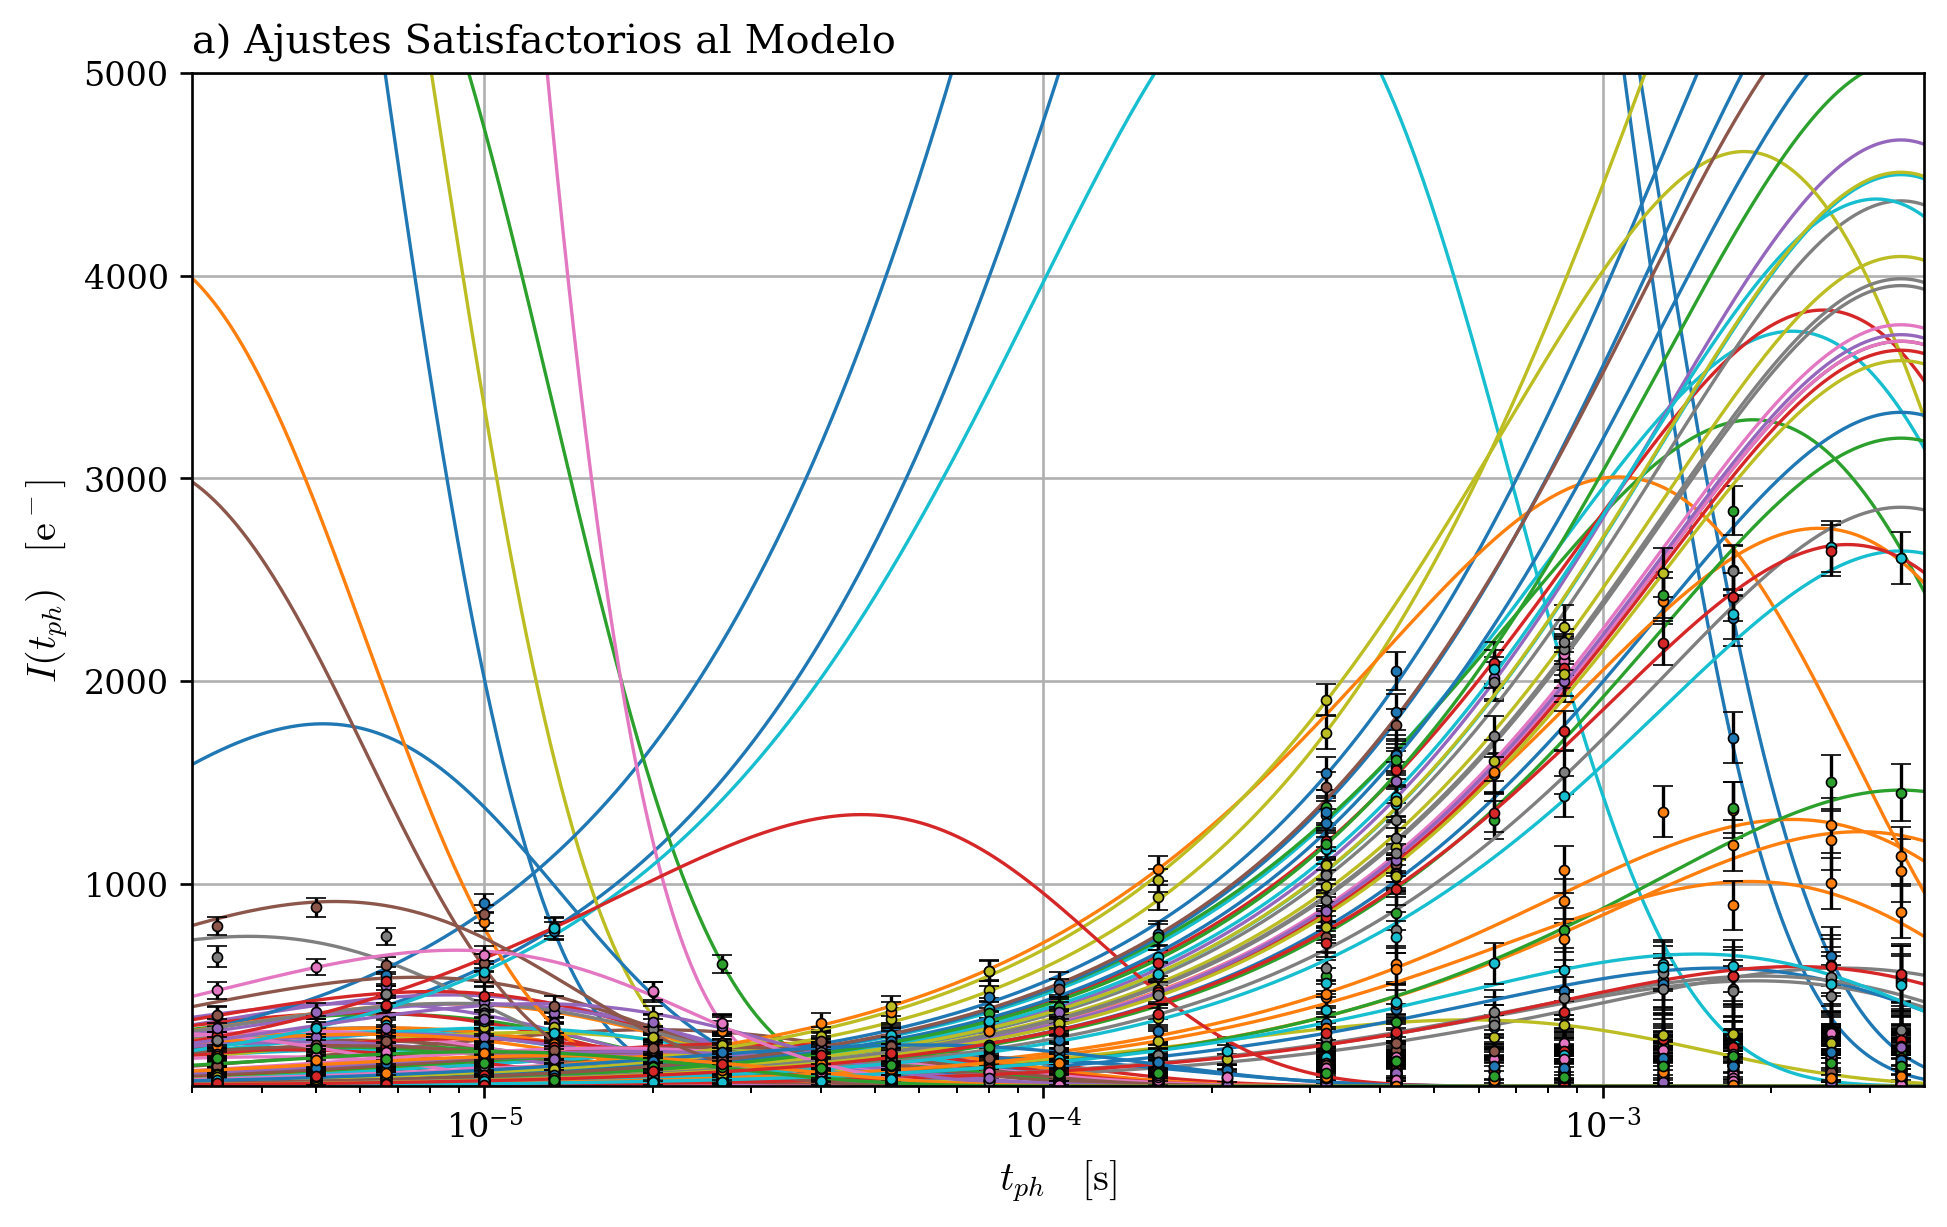

In [20]:
# Ajustamos los datos (enmascarando por saturación) a las curvas I(t_ph)
fig, ax = plt.subplots(1, 1, sharex=True, layout="constrained", figsize=(8, 5))
axs = [ax,]
# Para los ajustes satisfactorios
axs[0].set_title("a) Ajustes Satisfactorios al Modelo", loc="left")

plot_idx = 0
skip_plot = False
trampas_ajustadas = []
tau_ajustados = []
err_tau_ajustados = []
pc_ajustados = []
temps_datos_ajustados = []
intensidades_ajustadas = []
error_intensidades_ajustadas = []
tph_ajustados = []
mascaras_ajustadas = []
# Para la extracción de máximos
# axs[1].set_title("b) Extracción del Máximo (muestra)", loc="left")
plot_count = 0
random_plot_gen = np.random.default_rng(2024)
# trampas_seleccionadas = []
# maximos_seleccionados = []
# error_maximos_seleccionados = []
# temps_maximos_seleccionados = []
# intensidades_seleccionadas = []
# error_intensidades_seleccionadas = []
# tph_seleccionados = []
dtph_dense = np.geomspace(DTPH_VALS[0]/1.5, DTPH_VALS[-1]*1.5, 1000)

for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for dir_idx in range(len(carpetas)):
        for frame_idx in [0, 1]:
            dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
            # error_vals = np.array(error_temp[temperatura][2*dir_idx + frame_idx])
            # error_vals = np.sqrt(
            #     np.array(error_temp[temperatura][2*dir_idx + frame_idx])**2
            #     + (60/np.sqrt(2))**2
            # )  # Agregando al error de lectura la variación de la intensidad
            for coord_idx, (
                coords,
                intensidades,
                errores,
                mascara_saturacion,
            ) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                    mascara_saturacion_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                if np.sum(~mascara_saturacion) < 6:
                    # Si hay menos de 5 puntos para ajustar, no se hace el ajuste
                    continue
                dtph_mask = dtph_vals[~mascara_saturacion]
                intensidades_mask = np.array(intensidades)[~mascara_saturacion]
                errores_mask = np.array(errores)[~mascara_saturacion]
                
                idx_pico = np.argmax(intensidades_mask)
                if (dtph_mask[idx_pico] in [dtph_vals[0], dtph_vals[-1]]):
                    continue
                dtph_maxval = dtph_mask[idx_pico]  # s
                # intensidad_maxval = intensidades_mask[idx_pico]  # e⁻
                intensidad_maxval = np.max(intensidades)  # e⁻
                # Ajustes al Modelo
                tau_estimado = dtph_maxval/np.log(2)  # CLOCKS
                pc_estimado = intensidad_maxval*4/40_000
                try:
                    popt, pcov = curve_fit(
                        intensidad_func,
                        dtph_mask,
                        intensidades_mask,
                        sigma=errores_mask,
                        p0=[tau_estimado, pc_estimado],
                        bounds=(
                            [DTPH_VALS[0], pc_estimado*0.9],
                            [DTPH_VALS[-1]/np.log(2), np.inf],
                        ),
                    )
                except RuntimeError:
                    continue
                perr = np.sqrt(np.diag(pcov))
                # Chi² del fit
                grados_libertad = len(dtph_mask) - len(popt)
                chi2_obs = np.sum(
                    (
                        (intensidades_mask - intensidad_func(dtph_mask, *popt))
                        / errores_mask
                    )**2
                )
                p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
                if (p_value > 0.05):  # Si el ajuste es satisfactorio
                    if coords[-1] in trampas_ajustadas:  # Si ya ajusté esta trampa
                        # trampa_idx = trampas_ajustadas.index(coords[-1])
                        # color = f"C{trampa_idx%10}"
                        skip_plot = True
                    # elif plot_idx > 10:
                    #     skip_plot = True
                    else:  # Si es una trampa nueva
                        color = f"C{plot_idx%10}"
                        plot_idx += 1
                    trampas_ajustadas.append(coords[-1])
                    tau_ajustados.append(popt[0]/CLOCKS_TO_SEC)  # s
                    err_tau_ajustados.append(perr[0]/CLOCKS_TO_SEC)  # s
                    pc_ajustados.append(popt[1])  # e⁻
                    temps_datos_ajustados.append(temperatura)  # K
                    intensidades_ajustadas.append(intensidades)  # e⁻
                    error_intensidades_ajustadas.append(errores)  # e⁻
                    tph_ajustados.append(dtph_vals/CLOCKS_TO_SEC)  # s
                    mascaras_ajustadas.append(mascara_saturacion)
                    # Lo que queda del bloque son solo gráficos
                    if not skip_plot:
                        axs[0].plot(
                            dtph_dense/CLOCKS_TO_SEC,
                            intensidad_func(dtph_dense, *popt),
                            c=color, lw=1,
                        )
                        axs[0].errorbar(
                            dtph_mask/CLOCKS_TO_SEC,
                            intensidades_mask,
                            yerr=errores_mask,
                            fmt=f".{color}",
                            label=f"{coords[-1]} | {temperatura} K",
                            markeredgecolor="k", markeredgewidth=0.5,
                            linestyle="",
                            ecolor="k", elinewidth=1, capsize=3,
                        )
                    skip_plot = False
                # Selección de Máximos (filtrando de máximos espurios)
                # intensidades_sin_pico = intensidades_mask.copy()
                # intensidades_sin_pico[idx_pico] = 0
                # idx_pico_2 = np.argmax(intensidades_sin_pico)
                # if (
                #     (abs(idx_pico_2 - idx_pico) == 1)  # Sus vecinos también son máximos
                #     and (intensidades_mask[idx_pico_2]/intensidad_maxval > 0.5)  # El segundo es casi tan alto como el primero
                # ):
                #     error_determinacion_pico = np.min(
                #         np.diff(dtph_mask[idx_pico-1:idx_pico+2])
                #     )
                #     trampas_seleccionadas.append(coords[-1])
                #     maximos_seleccionados.append(dtph_maxval/CLOCKS_TO_SEC)  # s
                #     error_maximos_seleccionados.append(error_determinacion_pico/CLOCKS_TO_SEC)  # s
                #     temps_maximos_seleccionados.append(temperatura)  # K
                #     intensidades_seleccionadas.append(intensidades_mask)  # e⁻
                #     error_intensidades_seleccionadas.append(errores_mask)  # e⁻
                #     tph_seleccionados.append(dtph_mask/CLOCKS_TO_SEC)  # s
                    
                #     # De acá para abajo es solo gráficos
                #     if (plot_count > 3) or (random_plot_gen.random() > 0.1):
                #         continue
                #     axs[1].plot(
                #         dtph_dense/CLOCKS_TO_SEC,
                #         intensidad_func(dtph_dense, *popt),
                #         ls="--", alpha=0.5, c=f"C{plot_idx%10}"
                #     )
                #     axs[1].errorbar(
                #         dtph_mask/CLOCKS_TO_SEC,
                #         intensidades_mask,
                #         yerr=errores_mask,
                #         fmt=f".C{plot_idx%10}", label=f"{coords[-1]} | {temperatura} K",
                #         markeredgecolor="k", markeredgewidth=0.5,
                #         linestyle="", alpha=1,
                #         ecolor="k", elinewidth=1, capsize=3,
                #     )
                #     axs[1].errorbar(
                #         dtph_maxval/CLOCKS_TO_SEC,
                #         intensidad_maxval,
                #         yerr=errores_mask[idx_pico],
                #         xerr=error_determinacion_pico/CLOCKS_TO_SEC,
                #         fmt=f"^C{plot_idx%10}",
                #         markeredgecolor="k", markeredgewidth=0.5,
                #         markersize=7.5, alpha=1,
                #         ecolor="k", elinewidth=1, capsize=3,
                #         zorder=10,
                #     )
                #     axs[1].plot(
                #         [dtph_maxval/CLOCKS_TO_SEC, dtph_maxval/CLOCKS_TO_SEC],
                #         [0, intensidad_maxval],
                #         ls="-", c="k", zorder=5, lw=1
                #     )
                #     plot_count += 1
                #     plot_idx += 1
# for ax in axs:
ax.grid()
# ax.legend(title="Coordenadas | T", loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xscale("log")
ax.set_xlabel("$t_{ph}\quad\mathrm{[s]}$")
ax.set_xlim(left=50/CLOCKS_TO_SEC*0.9, right=51200/CLOCKS_TO_SEC*1.1)
# ax.set_yscale("log")
ax.set_ylabel("$I(t_{ph})\quad\mathrm{[e^-]}$")
ax.set_ylim(bottom=1, top=5e3)
# ax.set_ylim(top=1.5e3)
plt.show()

resultados_ajustes = pd.DataFrame(
    data={
        "Trampa": trampas_ajustadas,
        "Tau": tau_ajustados,
        "Error Tau": err_tau_ajustados,
        "Pc": pc_ajustados,
        "Temperatura": temps_datos_ajustados,
        "Intensidad": intensidades_ajustadas,
        "Error Intensidad": error_intensidades_ajustadas,
        "tph": tph_ajustados,
        "Máscara": mascaras_ajustadas,
    }
)
# resultados_maximos = pd.DataFrame(
#     data={
#         "Trampa": trampas_seleccionadas,
#         "t_max": maximos_seleccionados,
#         "Error t_max": error_maximos_seleccionados,
#         "Temperatura": temps_maximos_seleccionados,
#         "Intensidad": intensidades_seleccionadas,
#         "Error Intensidad": error_intensidades_seleccionadas,
#         "tph": tph_seleccionados,
#     }
# )

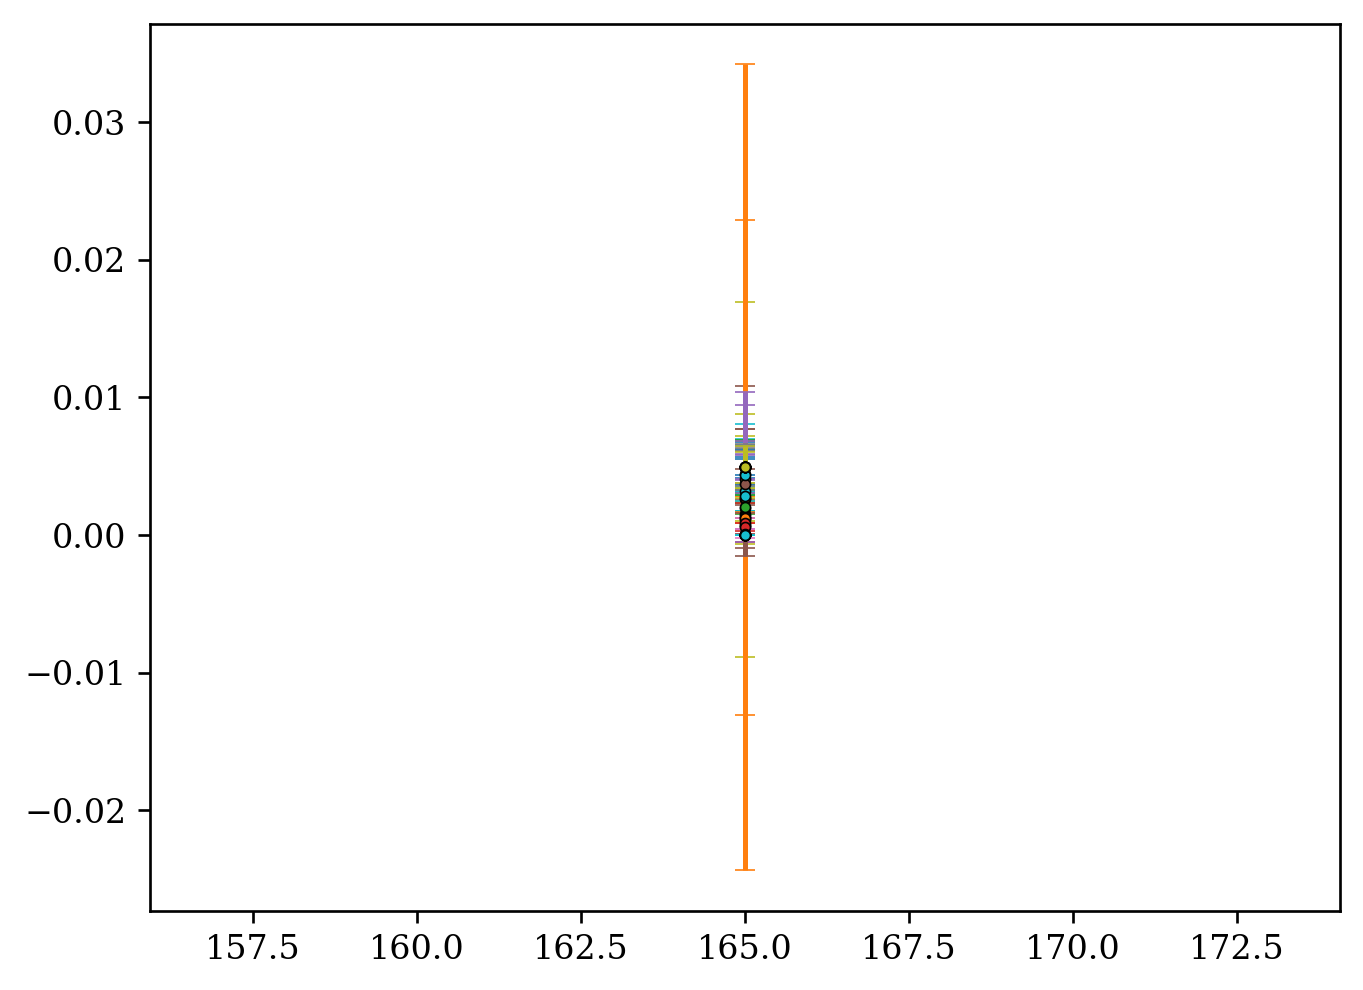

In [22]:
# Simplificamos los repetidos tomando el promedio ponderado por el error
trampas_unicas = set(trampas_ajustadas)
for coord in trampas_unicas:
    if trampas_ajustadas.count(coord) == 1:
        continue
    filtro_trampa = (resultados_ajustes["Trampa"] == coord)
    for temperatura in CARPETAS_POR_TEMP.keys():
        filtro_temp = (resultados_ajustes["Temperatura"] == temperatura)
        if sum(filtro_trampa & filtro_temp) > 1:
            plt.errorbar(
                resultados_ajustes.loc[filtro_trampa & filtro_temp, "Temperatura"],
                resultados_ajustes.loc[filtro_trampa & filtro_temp, "Tau"],
                yerr=resultados_ajustes.loc[filtro_trampa & filtro_temp, "Error Tau"],
                fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
            )
            # Join this datapoints by averaging them
            resultados_ajustes.loc[filtro_trampa & filtro_temp, "Tau"] = np.average(
                resultados_ajustes.loc[filtro_trampa & filtro_temp, "Tau"],
                weights=1/resultados_ajustes.loc[filtro_trampa & filtro_temp, "Error Tau"]**2,
            )
            resultados_ajustes.loc[filtro_trampa & filtro_temp, "Error Tau"] = np.sqrt(
                1/np.sum(1/resultados_ajustes.loc[filtro_trampa & filtro_temp, "Error Tau"]**2)
            )
            # plt.errorbar(
            #     resultados_ajustes.loc[filtro_trampa & filtro_temp, "Temperatura"],
            #     resultados_ajustes.loc[filtro_trampa & filtro_temp, "Tau"],
            #     yerr=resultados_ajustes.loc[filtro_trampa & filtro_temp, "Error Tau"],
            #     fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
            # )
resultados_ajustes.drop_duplicates(
    subset=["Trampa", "Temperatura"], keep="first", inplace=True
)
resultados_ajustes.reset_index(drop=True, inplace=True)


[(62, 231) (132, 560) (385, 50) (568, 458) (585, 478) (602, 233) (686, 86)]
7
Trampa de ejemplo: (602, 233)
Trampa de ejemplo: (62, 231)


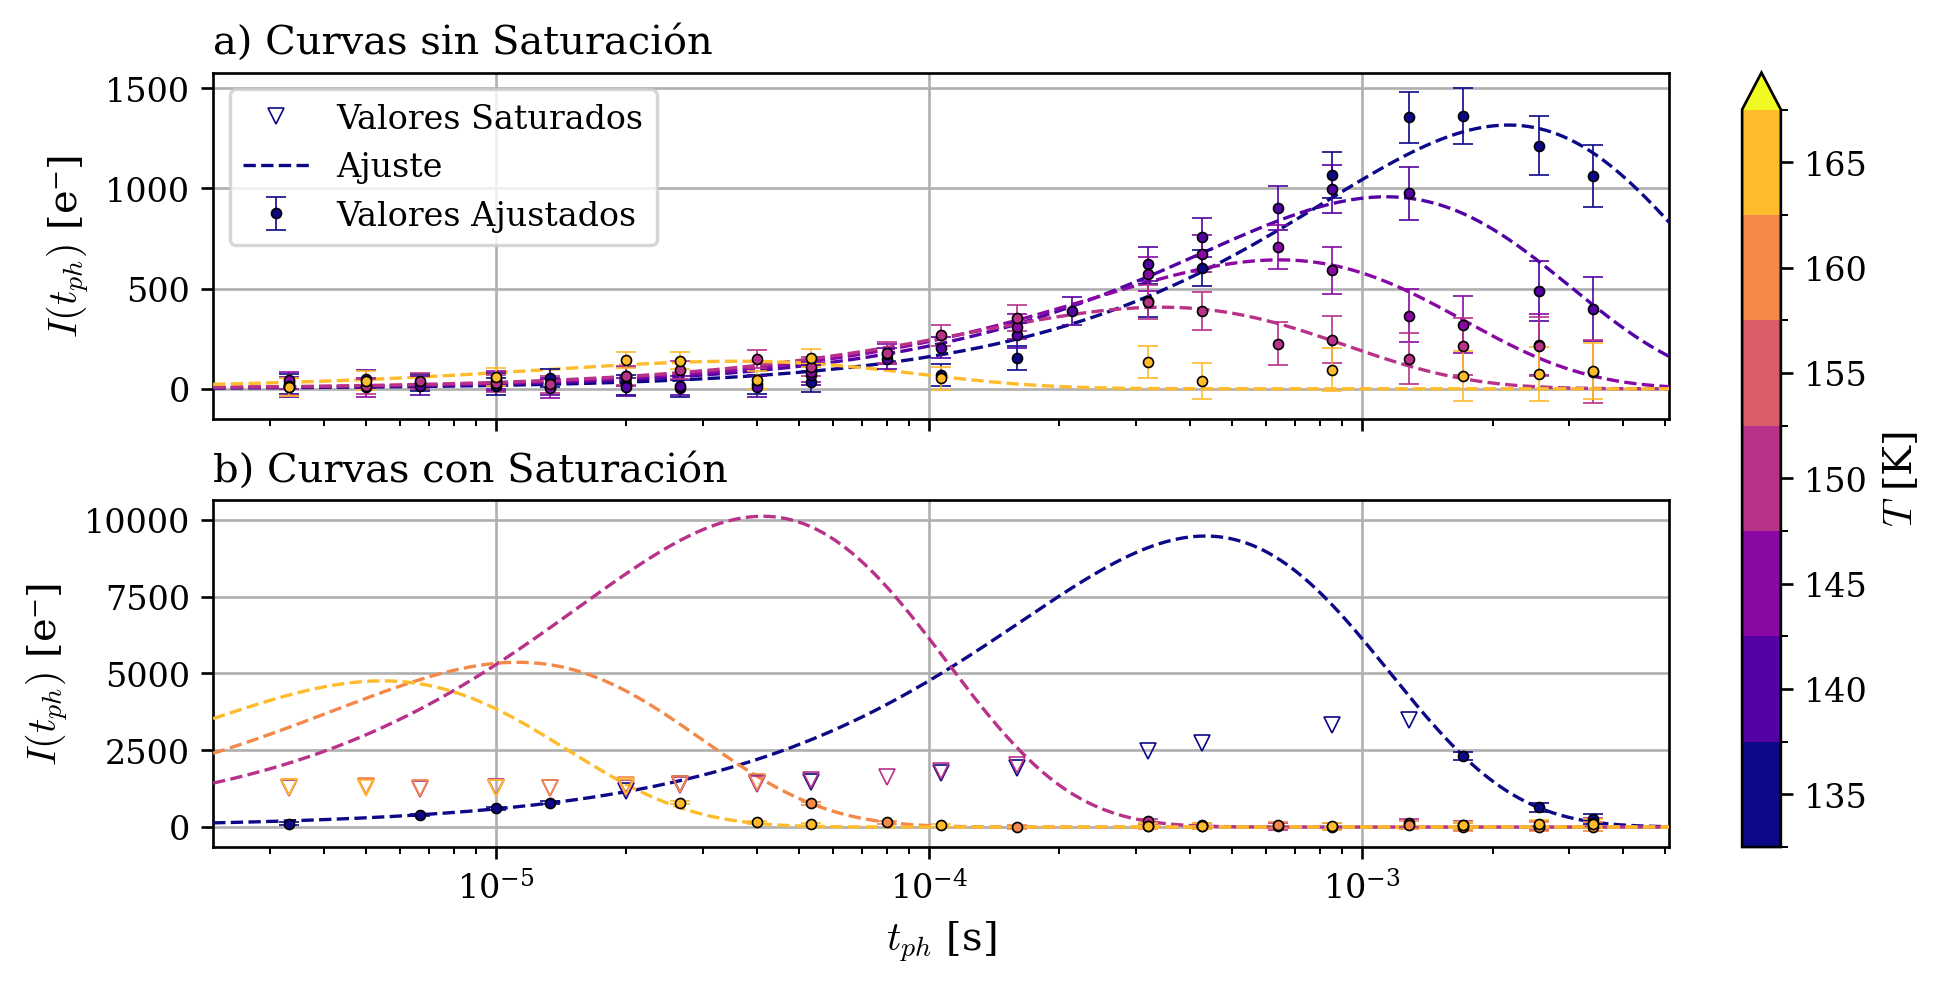

In [29]:
# Graficamos una trampa de ejemplo para varias temperaturas
# trampa_ejemplo = (783, 197)
trampas_unicas, counts = np.unique(
    resultados_ajustes["Trampa"], return_counts=True
)
trampas_varias = trampas_unicas[counts >= 3]
print(trampas_varias)
print(len(trampas_varias))
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, layout="constrained", figsize=(8, 4))
axs[0].set_title("a) Curvas sin Saturación", loc="left")
axs[1].set_title("b) Curvas con Saturación", loc="left")
tph_dense = np.geomspace(DTPH_VALS[0]/1.5, DTPH_VALS[-1]*1.5, 1000)/CLOCKS_TO_SEC
for trampa_idx, ax in zip([5, 0], axs):
    trampa_ejemplo = trampas_varias[trampa_idx]
    print(f"Trampa de ejemplo: {trampa_ejemplo}")
    filtro_trampa = (resultados_ajustes["Trampa"] == trampa_ejemplo)

    # text_kwargs_by_temp = {
    #     165: {"va": "bottom", "ha": "center"},
    #     160: {"va": "bottom", "ha": "center"},
    #     150: {"va": "bottom", "ha": "right"},
    #     140: {"va": "center", "ha": "right"},
    #     145: {"va": "bottom", "ha": "right"},
    #     135: {"va": "bottom", "ha": "center"},
    # }
    # text_pad_by_temp = {
    #     165: (0, 100),
    #     160: (0, 50),
    #     150: (0, 50),
    #     140: (-3e-4, 0),
    #     145: (0, 50),
    #     135: (0, 50),
    # }
    for temp, tph_vals, intensidades, errores, mascara_saturacion, tau, pc in zip(
        resultados_ajustes.loc[filtro_trampa, "Temperatura"],
        resultados_ajustes.loc[filtro_trampa, "tph"],
        resultados_ajustes.loc[filtro_trampa, "Intensidad"],
        resultados_ajustes.loc[filtro_trampa, "Error Intensidad"],
        resultados_ajustes.loc[filtro_trampa, "Máscara"],
        resultados_ajustes.loc[filtro_trampa, "Tau"],
        resultados_ajustes.loc[filtro_trampa, "Pc"],
    ):
        tph_vals = np.array(tph_vals)
        intensidades = np.array(intensidades)
        errores = np.array(errores)
        ax.plot(
            tph_vals[mascara_saturacion],
            intensidades[mascara_saturacion],
            "v", c="none",
            mec=temp_colors.to_rgba(temp), mew=0.5, ms=5, zorder=10,
            label="Valores Saturados" if temp == 135 else None
        )
        ax.errorbar(
            tph_vals[~mascara_saturacion],
            intensidades[~mascara_saturacion],
            yerr=errores[~mascara_saturacion],
            fmt=".", c=temp_colors.to_rgba(temp),
            mec="k", mew=0.5, capsize=3, elinewidth=0.5, zorder=20,
            label="Valores Ajustados" if temp == 135 else None
        )
        
        ax.plot(
            tph_dense,
            intensidad_func(tph_dense, tau, pc),
            "--",
            c=temp_colors.to_rgba(temp),
            lw=1, zorder=5,
            label="Ajuste" if temp == 135 else None
        )
        # ax.text(
        #     tph_vals[max_idx] + text_pad_by_temp[temp][0],
        #     intensidades[max_idx] + text_pad_by_temp[temp][1],
        #     f"{temp} K",
        #     c=temp_colors.to_rgba(temp),
        #     **text_kwargs_by_temp[temp]
        # )
    ax.grid()
    ax.set_xscale("log")
    
    
    # plt.yscale("log")
axs[0].legend()
for ax in axs:
    ax.set_ylabel("$I(t_{ph})$ [e⁻]")
    ax.set_xlim(tph_dense[0], tph_dense[-1])
axs[1].set_xlabel("$t_{ph}$ [s]")
# axs[1].yaxis.tick_right()
# axs[1].yaxis.set_label_position("right")
fig.colorbar(temp_colors, label="$T$ [K]", extend="max", ax=axs,
             ticks=temp_colors.norm.boundaries+2.5)
plt.show()

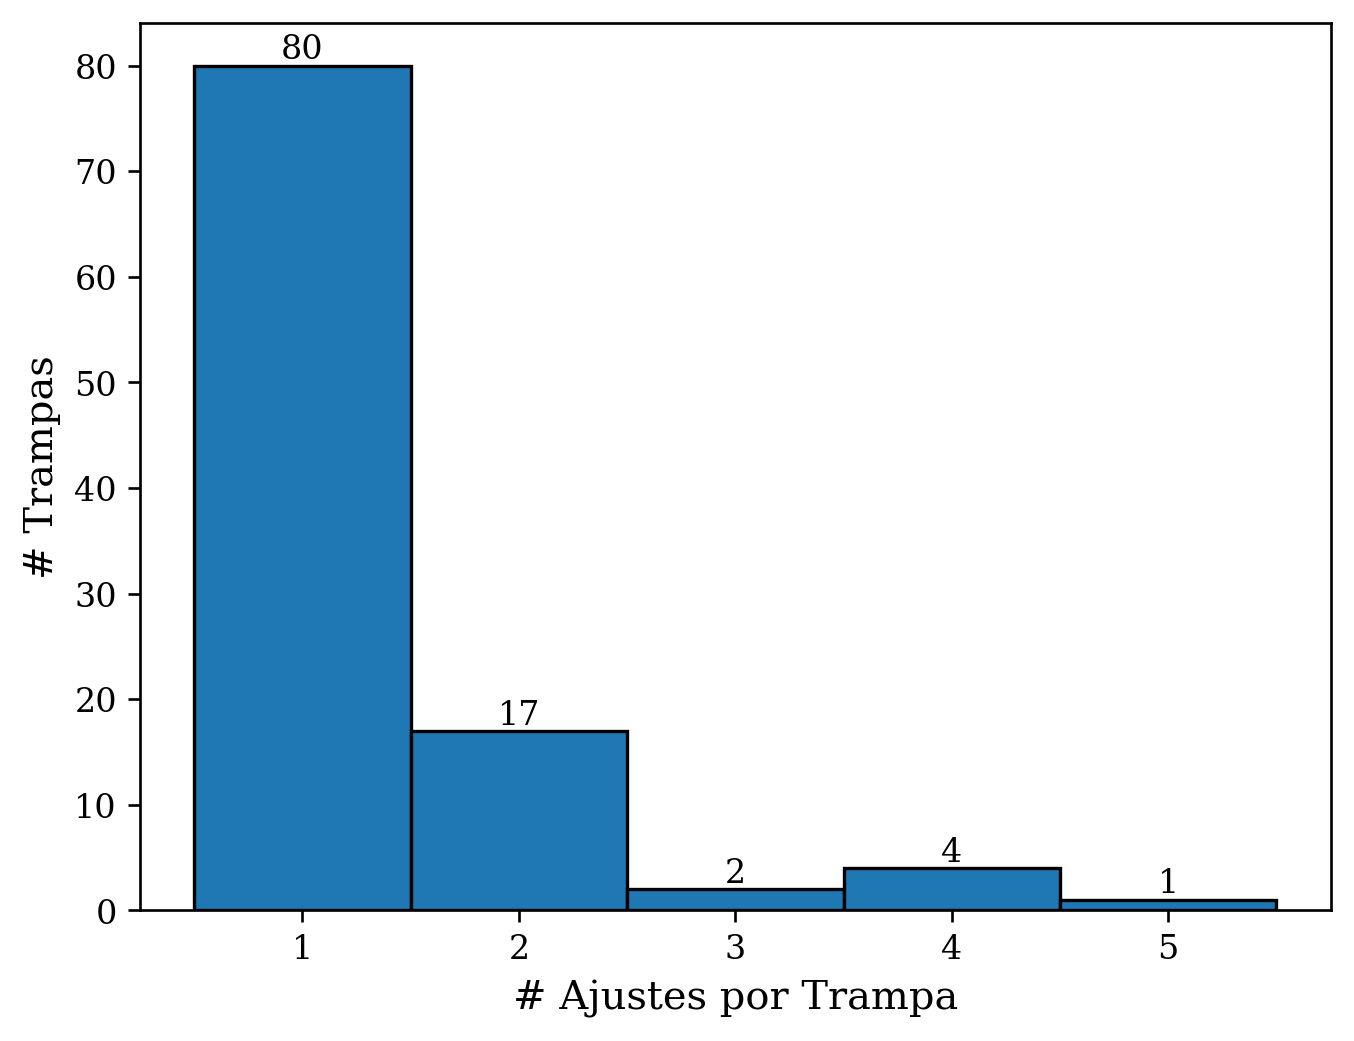

In [24]:
# Histograma de Número de Ajustes Satisfactorios por Trampa
cuentas = resultados_ajustes["Trampa"].value_counts().values
counts, bins = np.histogram(cuentas, bins=np.arange(0.5, cuentas.max() + 1.5, 1))
plt.bar(bins[:-1], counts, width=1, align="edge", ec="k")
for count, bin in zip(counts, bins[:-1]):
    plt.text(
        bin + 0.5,
        count,
        f"{count}",
        ha="center", va="bottom",
    )
plt.xlabel("# Ajustes por Trampa")
plt.ylabel("# Trampas")
plt.show()

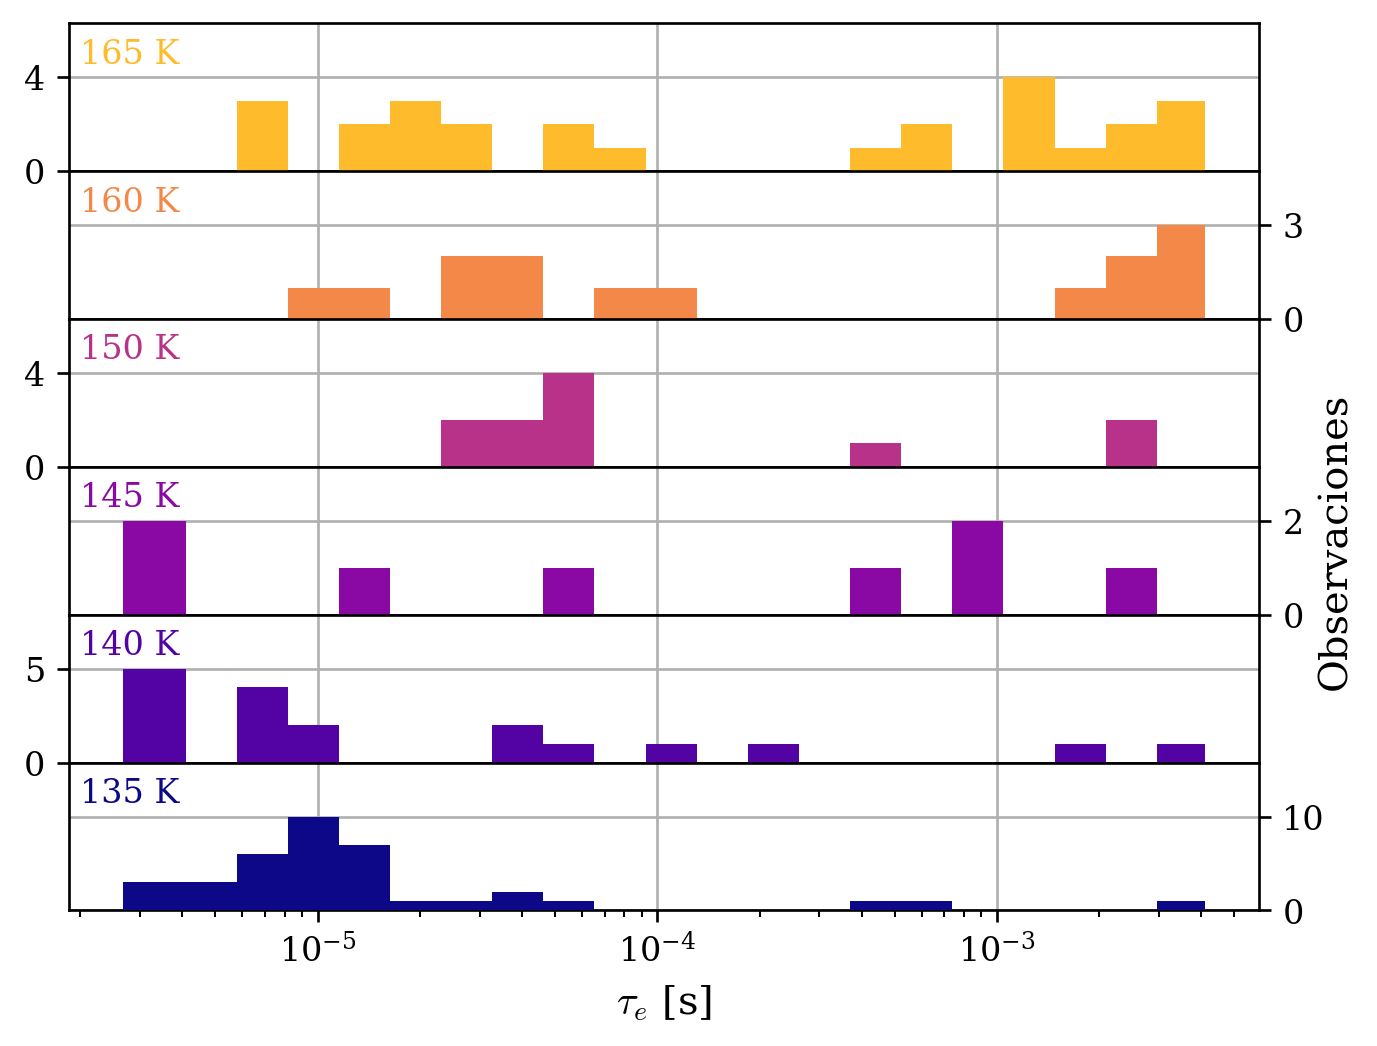

In [25]:
# Gráfico de la distribución de Tau_e a medida que aumenta la temperatura
fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True,)
# Sin dejar espacio entre los axs
fig.subplots_adjust(hspace=0)
plot_idx = 0
for temperatura, ax in zip(CARPETAS_POR_TEMP.keys(), axs[::-1]):
    ax.hist(
        resultados_ajustes[resultados_ajustes["Temperatura"] == temperatura]["Tau"],
        bins=DTPH_BINS/CLOCKS_TO_SEC,
        facecolor=temp_colors.to_rgba(temperatura),
        zorder=5,
    )
    # vals, counts = np.unique(
    #     resultados_ajustes[resultados_ajustes["Temperatura"] == temperatura]["Tau"],
    #     return_counts=True,
    # )
    # ax.stem(
    #     vals/CLOCKS_TO_SEC,
    #     counts,
        
    # )
    ax.text(
        0.01, 0.9,
        f"{temperatura} K",
        transform=ax.transAxes,
        ha="left", va="top", c=temp_colors.to_rgba(temperatura),
    )
    ax.grid()
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1]*1.5)
    ax.set_yticks([0, int(ylims[1])])
    if temperatura == 145:
        ax.set_ylabel("Observaciones")
    if not plot_idx % 2:
        # ticks a la derecha
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    plot_idx += 1
ax.set_xscale("log")
axs[-1].set_xlabel(r"$\tau_e$ [s]")
# fig.colorbar(temp_colors, label="$T$ [K]", ax=axs,
#              ticks=temp_colors.norm.boundaries+2.5, location="left", )
plt.show()

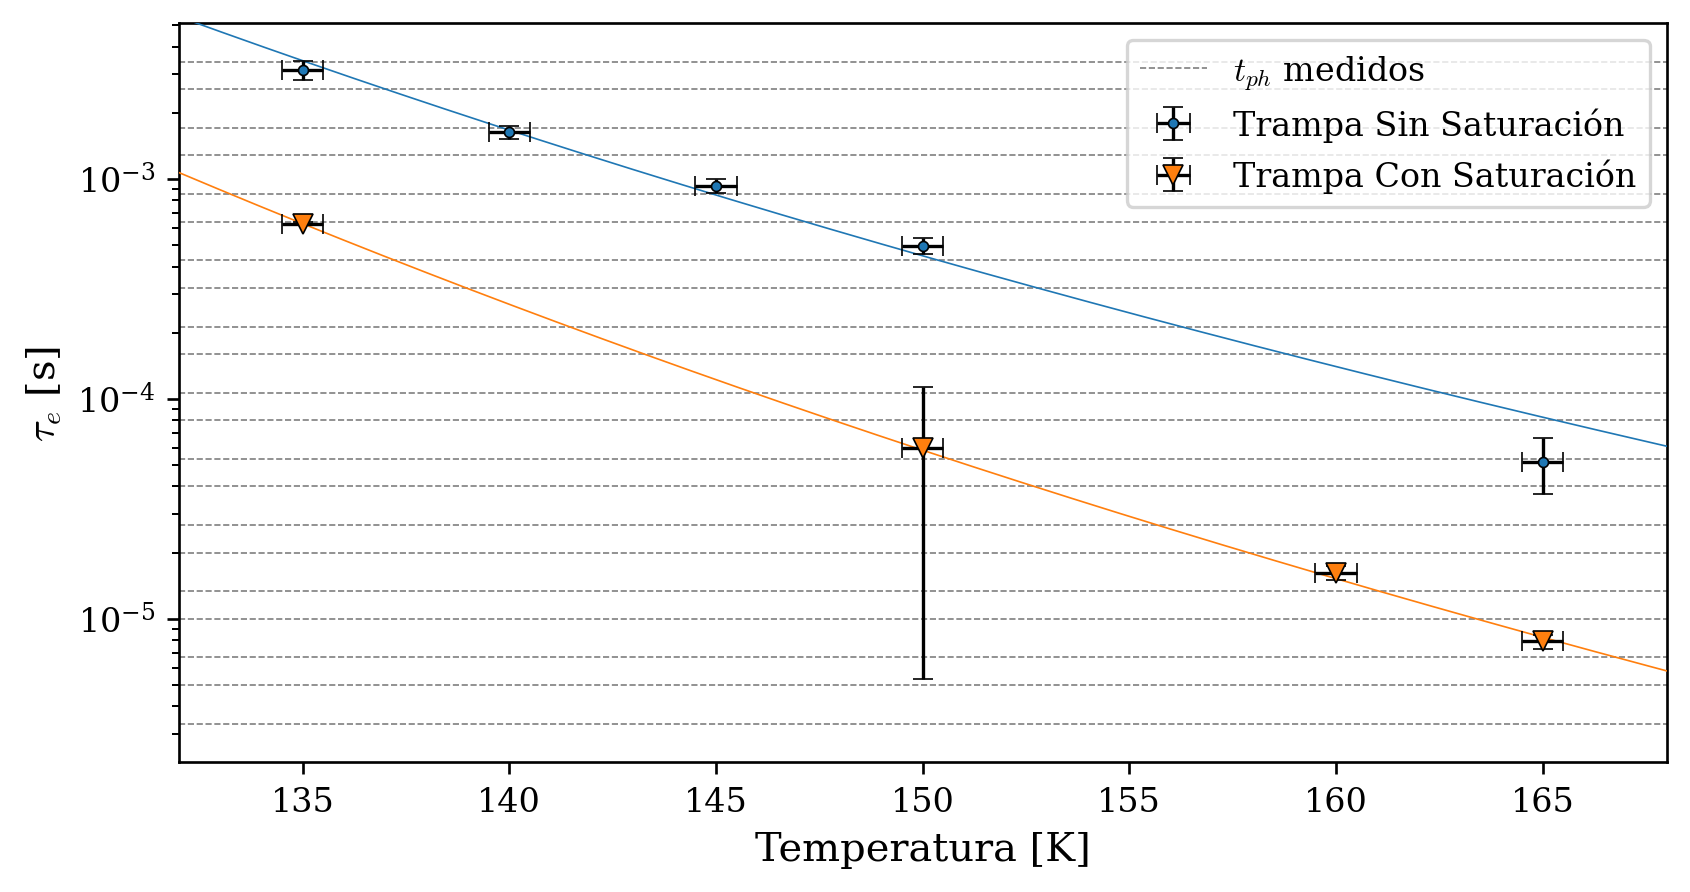

In [54]:
# Buscamos trampas que aparecen en varias temperaturas y graficamos con el ajuste
fig = plt.figure(figsize=(8, 4))
trampas_unicas = set(trampas_ajustadas)
trampas_en_muchas_temps = []
temps_dense = np.linspace(132, 168, 1000)
plot_idx = 0
# for coord in trampas_unicas:
for coord, marker, tag in zip(
    [(602, 233), (62, 231)],
    [".", "v"],
    ["Trampa Sin Saturación", "Trampa Con Saturación"]
):
    if sum(resultados_ajustes["Trampa"] == coord) >= 4:
        trampas_en_muchas_temps.append(coord)
        filtro_trampa = (resultados_ajustes["Trampa"] == coord)
        temps = resultados_ajustes.loc[filtro_trampa, "Temperatura"]
        tau_vals = resultados_ajustes.loc[filtro_trampa, "Tau"]
        tau_errs = resultados_ajustes.loc[filtro_trampa, "Error Tau"]
        try:
            popt, pcov = curve_fit(
                tau_func,
                temps,
                tau_vals,
                sigma=tau_errs,
                bounds=([0, 0], [np.inf, np.inf]),
            )
        except RuntimeError:
            continue
        # Chi2 del fit
        grados_libertad = len(temps) - len(popt)
        chi2_obs = np.sum(
            (
                (tau_vals - tau_func(temps, *popt))
                / tau_errs
            )**2
        )
        p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
        
        plt.errorbar(
            temps,
            tau_vals,
            yerr=tau_errs,
            xerr=0.5,
            fmt=marker, mec="k", mew=0.5, c=f"C{plot_idx%10}",
            ls="none",
            ecolor="k", elinewidth=1, capsize=3,
            label=tag,
            zorder=12 + plot_idx,
        )
        # plt.scatter(
        #     temps,
        #     tau_vals,
        #     c=temp_colors.to_rgba(temps),
        #     marker=marker,
        #     edgecolors="k",
        #     linewidths=0.5,
        #     s=25,
        #     label=tag,
        #     zorder=15 + plot_idx,
        # )
        plt.plot(
            temps_dense,
            tau_func(temps_dense, *popt),
            "-", c=f"C{plot_idx%10}", lw=0.5,
            zorder=3 + plot_idx,
        )
        plot_idx += 1
plt.hlines(
    DTPH_VALS/CLOCKS_TO_SEC,
    xmin=temps_dense[0], xmax=temps_dense[-1],
    colors="k", linestyles="--", lw=0.5, alpha=0.5, zorder=1,
    label="$t_{ph}$ medidos"
)
# plt.grid()
plt.legend(
    # loc="upper left", bbox_to_anchor=(1, 1), frameon=False
)
plt.xlabel("Temperatura [K]")
plt.xlim(temps_dense[0], temps_dense[-1])
plt.yscale("log")
plt.ylabel(r"$\tau_e$ [s]")
plt.ylim(DTPH_VALS[0]/CLOCKS_TO_SEC/1.5, DTPH_VALS[-1]/CLOCKS_TO_SEC*1.5)
plt.show()